# Neural Networks: Building Blocks

In [2]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
from jax import grad, jit
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib_inline.backend_inline import set_matplotlib_formats
from matplotlib.colors import LogNorm
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
from typing import List, Callable

mpl.rcParams['mathtext.fontset']='cm'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from keras.datasets import mnist

set_matplotlib_formats("retina")

## A Single Neuron

Neurons are at the core of artificial neural networks. Like the networks they form, they are inspired by their biological counterparts but are not models of them.

A neuron weighs its inputs separately and passes their sum through an activation function. The result of this operation is the neuron's ***activation***. Typically, a bias is added to the weighted sum of the inputs to allow a left- or rightward shift of the activation function.

$$y = σ(w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3} + ... + w_{n}x_{n} + b)$$

$$y = σ(\sum\limits_{i=1}^n w_{i}x_{i} + b)$$

where the neuron's activation $y$ is determined by a sigmoid activation function $σ$, the neuron's weights $w_{n}$, its inputs $x_{n}$, and a bias $b$.

<p align="center">
    <img src="assets/perceptron.svg" width=35% alt="A single neuron"/>
</p>


The weights and inputs can be represented as tensors and the weighted sum can be therefore computed as a dot product between the weight tensor $w$ and the input tensor $x$. 

$$y = \sigma(w⋅x  + b)$$

One advantage of computing the weighted sum as a dot product is that we can leverage efficient, highly-parallelized libraries such as CUDA or BLAS (Basic Linear Algebra Subprograms) implementations.

In [84]:
weights = np.array([0.1, 0.2, 0.3])
input = np.array([0.2, 0.3, 0.1])
bias = 1

sum([w * x for w, x in zip(weights, input)]) + bias

1.11

In [85]:
np.dot(weights, input) + bias

1.11

The operation of calculating the output of a neural network based on some input is called a ***forward pass*** or, more generally, ***forward propagation***.

In [95]:
class Neuron():

    def __init__(self, weights, bias):
        self.weights = weights
        self.bias = bias

    def forward(self, input):
        """A forward pass through the neuron"""
        z = np.dot(self.weights, input) + self.bias
        print(f"Weighted sum = {z}")
        # Sigmoid activation function
        y = 1 / (1 + math.exp(-z))
        return y

neuron = Neuron(weights, bias)
print(f"Activation = {neuron.forward(input)}")

Weighted sum = [[1.11]]
Activation = 0.7521291114395702


*Note*: Neural networks consisting of a single neuron date back to the 1950s. The ***perceptron***, a machine learning algortihm used for binary classification, effectively consists of a single neuron using a [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) as its activation function.

### Activation Functions

Activation functions are analogous to the action potential in biological neurons. The activation function determines whether a neuron activates and to what extent.

Activation functions allow neural networks to *learn layered representations of the input data* and *account for non-linear relationships*.

If the output of a neuron were the weighted sum of its inputs, neural networks would simply represent a linear function. Even deep neural networks with several layers could be reduced to a linear function of their input. Moreover, linear hyperplanes (constant decision boundaries) are limited representations that do not capture non-linear effects.

*Mathematical note*: A function $f$ is linear if it's gradient is constant.

#### A Visualization of the Activation of a Linear and Non-Linear Neuron

Below is plotted the activation of a linear and non-linear neuron. The linear neuron has no activation function, i.e. its ouput is the sum of the weighted inputs and the bias. The non-linear neuron passes this sum through a sigmoid activation function. Both take two inputs $x_{1}$ and $x_{2}$. Each of the neurons is plotted with three different sets of weights.

In [51]:
def plot_activation(func):
    """Plot a 3d surface plot and heatmap of an activation function"""
    i = np.linspace(-10, 10, 100)
    x1, x2 = np.meshgrid(i, i)
    surface = plt.figure(figsize=plt.figaspect(0.25))
    raster = plt.figure(figsize=plt.figaspect(0.2))
    for idx, w in enumerate([[0.45, 0.9], [0.1, 0.2], [-0.35, 0.25]]):
        z = np.array([[func(weights=w, input=[_x1, _x2[0]], bias=1.5) for _x1 in x1[0]] for _x2 in x2])
        # 3d surface plot
        ax1 = surface.add_subplot(1, 3, 1+idx, projection="3d")
        ax1.plot_surface(x1, x2, z, rstride=2, cstride=2, cmap="plasma", linewidth=0, antialiased=True, shade=False)
        ax1.set_xlabel("x1")
        ax1.set_ylabel("x2")
        ax1.set_zlabel("Activation")
        ax1.title.set_text(f"Weights: {w}")
        ax1.view_init(azim=315)
        # Heatmap
        ax2 = raster.add_subplot(1, 3, 1+idx)
        im = ax2.imshow(z, cmap="plasma", interpolation="nearest", origin="lower", extent=[-10,10,-10,10])
        ax2.set_xlabel("x1")
        ax2.set_ylabel("x2")
        cb = raster.colorbar(im, ax=ax2)
        cb.set_label("Activation")

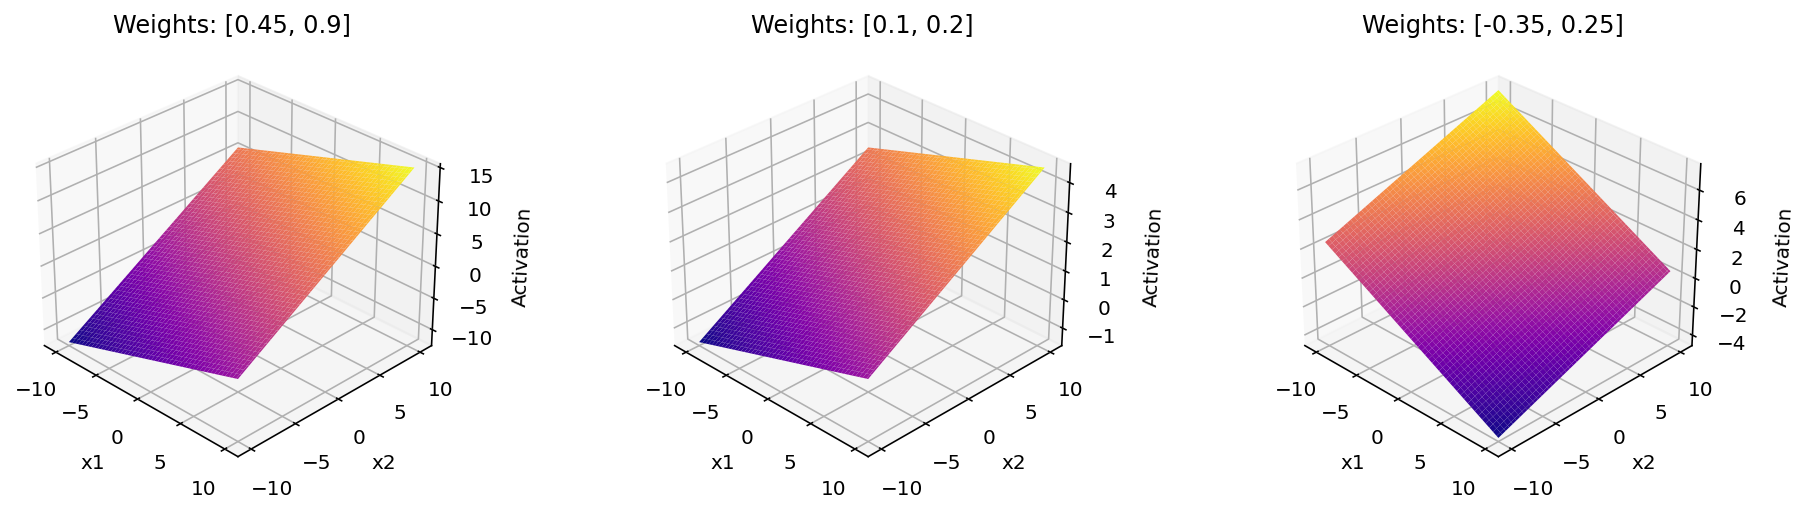

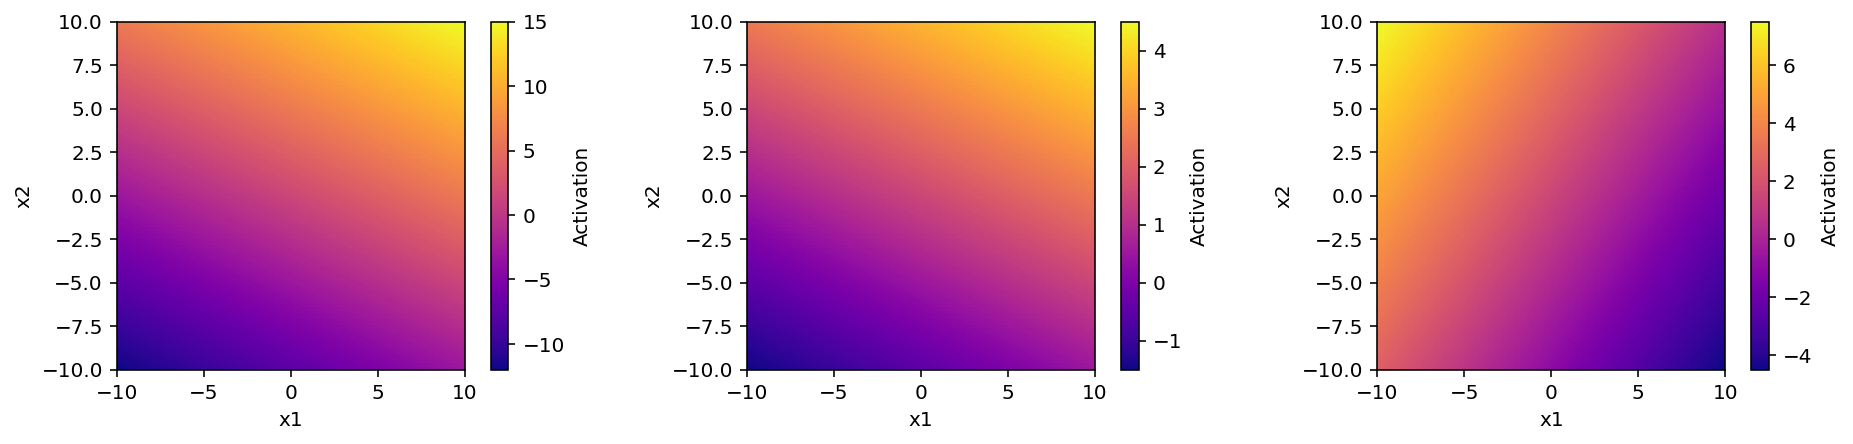

In [52]:
def linear(weights, input, bias):
    sum = np.dot(weights, input) + bias
    return sum

plot_activation(linear)

Note how changing the weights from $w_{1} = 0.45$ and $w_{2} = 0.9$ to $w_{1} = 0.1$ and $w_{2} = 0.2$ scales the neuron's activation but results in the same gradient when no activation function is applied. The same change of weights creates a new gradient when an activation function is used.

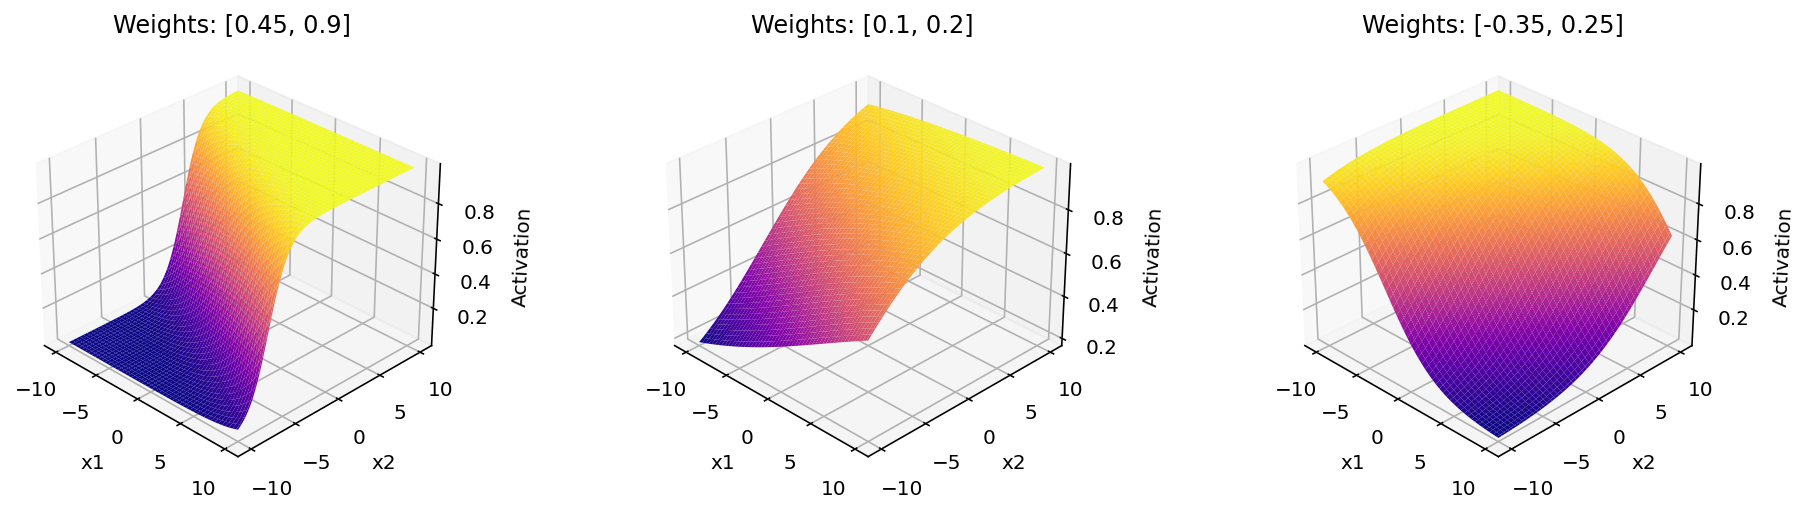

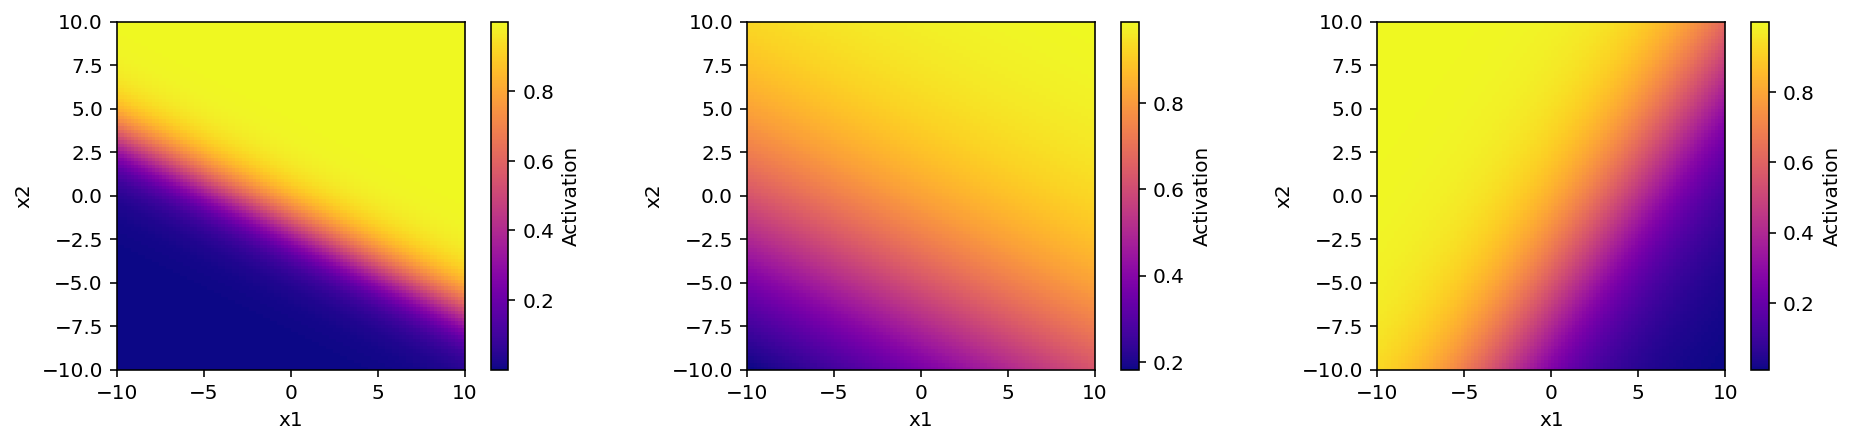

In [53]:
def nonlinear(weights, input, bias):
    sum = np.dot(weights, input) + bias
    y = 1 / (1 + math.exp(-sum))
    return y

plot_activation(nonlinear)

#### **Sigmoid**

Sigmoid (also known as logistic function) is a non-linear, continuously differentiable, monotonic activation function. It has a fixed range $(0,1)$. One of the issues of sigmoid is that it susceptible to the ***vanishing gradient problem***.

$$sigmoid(z) = \dfrac{1}{1 + e^{-z}}$$

$$sigmoid'(z) = sigmoid(z)(1-sigmoid(z))$$

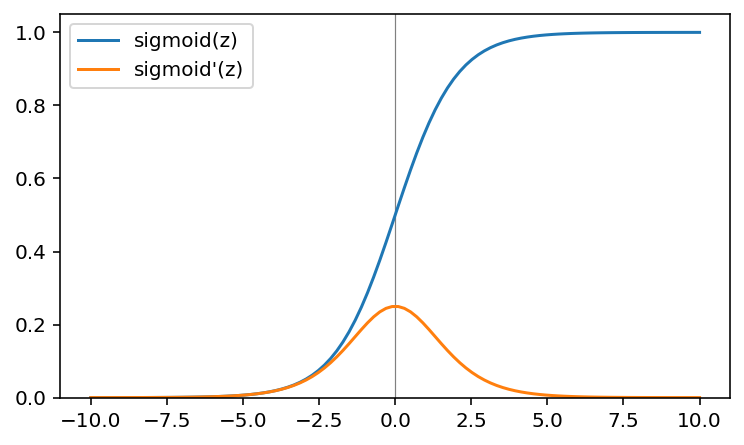

In [94]:
def sigmoid(z, derivative=False):
    """Sigmoid activation function"""
    if derivative:
        return sigmoid(z) * (1 - sigmoid(z))
    return 1 / (1 + np.exp(-z))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axvline(0, linewidth=0.6, color="grey")
ax.set_aspect(12)
z = np.linspace(-10, 10, 100)
plt.plot(z, sigmoid(z), label="sigmoid(z)")
plt.plot(z, sigmoid(z, derivative=True), label="sigmoid'(z)")
plt.legend()
plt.ylim(ymin=0)
plt.savefig("assets/sigmoid.png", dpi=200, bbox_inches='tight')
plt.show()

#### **Tanh**

Tanh is a non-linear, continuously differentiable activation function that comes from the same family of functions as sigmoid. However, tanh is *zero-centered*, meaning that the average of its inputs is zero. Zero-centered inputs and activations have been shown to improve the convergence of neural networks during training (see [Efficient BackProp](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf ) by LeCun et al.). Tanh is therefore often preferred to sigmoid, even though it also suffers from the vanishing gradient problem.

$$tanh(z) = \dfrac{e^z - e^{-z}}{e^z + e^{-z}}$$

$$tanh'(z) = 1 - tanh(z)^2$$

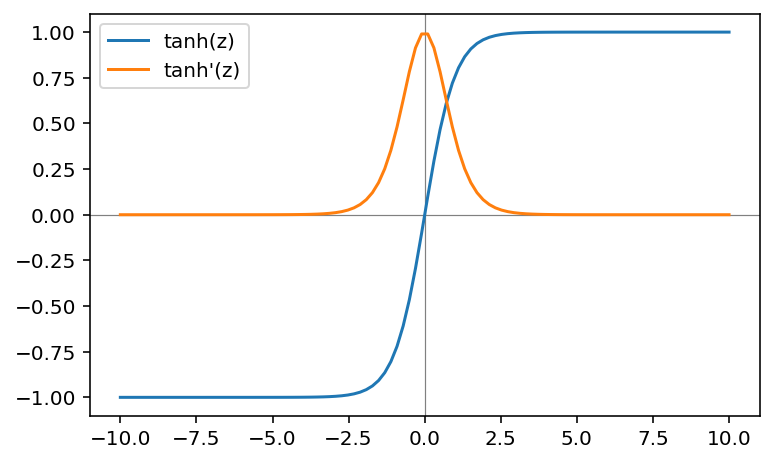

In [95]:
def tanh(z, derivative=False):
    """Tanh activation function"""
    if derivative:
        return 1 - np.power(tanh(z), 2)
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))    

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axvline(0, linewidth=0.6, color="grey")
ax.axhline(0, linewidth=0.6, color="grey")
ax.set_aspect(6)
z = np.linspace(-10, 10, 100)
plt.plot(z, tanh(z), label="tanh(z)")
plt.plot(z, tanh(z, derivative=True), label="tanh'(z)")
plt.legend()
plt.savefig("assets/tanh.png", dpi=200, bbox_inches='tight')
plt.show()

#### **Rectified Linear Unit (ReLU)**

ReLU is a non-linear activation function with a range $[0, ∞)$. ReLU is less computionally expensive than other activation functions because it involves simpler mathemtical operations, and therefore allows for faster training. Moreover neural networks using ReLU benefit from ***sparse activation***: not all neurons in a hidden are activated (activation > 0). However, ReLU neurons can suffer from the ***dying ReLU problem***.

$$ReLU(x) = max(0, x)$$

$$
ReLU'(x)=
\begin{cases} 
0 & \text{if  }  x < 0 \\
1 & \text{if  }  x > 0 \\
\end{cases}
$$

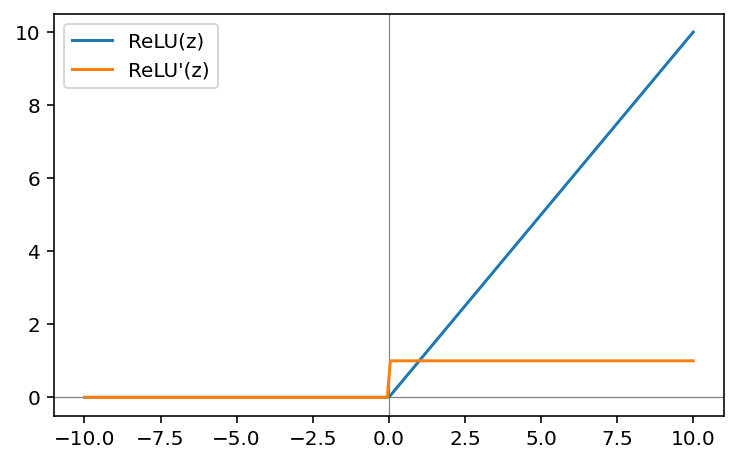

In [96]:
def relu(z, derivative=False):
    """ReLU activation function"""
    if derivative:
        return (z > 0) * 1
    return np.maximum(0, z)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axvline(0, linewidth=0.6, color="grey")
ax.axhline(0, linewidth=0.6, color="grey")
ax.set_aspect(1.2)
z = np.linspace(-10, 10, 200)
plt.plot(z, relu(z), label="ReLU(z)")
plt.plot(z, relu(z, derivative=True), label="ReLU'(z)")
plt.legend()
plt.savefig("assets/relu.png", dpi=200, bbox_inches='tight')
plt.show()

## A Network of Neurons

### Layers

A single neuron can only extract a limited representation on its own. In neural networks, neurons are therefore aggregated into connected ***layers***. Layers extract *representations* out of the data fed into them and, chained together, *progressively distillate the data*.

All weights in a layer can be represented as a matrix $W$ with $k$ neurons that each have $n$ weights. The sums of the weighted inputs of all neurons in the $n$-th layer can be calculated as a the matrix vector product between the weights matrix and the vector $a^{(n-1)}$ of the activations of the previous layer. The activation vector $a^{(n)}$ of the $n$-th layer is then the sum of the weighted inputs vector and the bias vector $b$, passed through an activation function.

$$
a^{(n)} = σ
\begin{pmatrix}
\begin{bmatrix}
w_{0,0} & w_{0,1} & \dots & w_{0,n} \\
w_{1,0} & w_{1,1} & \dots & w_{1,n} \\
\vdots  & \vdots  & \ddots & \vdots \\
w_{k,0} & w_{k,1} & \dots & w_{k,n} \\
\end{bmatrix}
\begin{bmatrix}
a_{0}^{(n-1)} \\
a_{1}^{(n-1)} \\
\vdots    \\
a_{n}^{(n-1)} \\
\end{bmatrix}
+
\begin{bmatrix}
b_{0} \\
b_{1} \\
\vdots \\
b_{n} \\
\end{bmatrix}
\end{pmatrix}
$$

$$a^{(n)} = σ(W^{n}a^{(n-1)} + b^{n})$$

In [104]:
weights = np.array([[0.18, 0.24, -0.2], [0.32, -0.15, 0.12], [0.6, -0.28, 0.46]])
input = np.array([[1.4], [0.62], [0.21]])
biases = np.array([[1], [3], [2]])

[relu(sum([w * x[0] for w, x in zip(neuron, input)]) + bias[0]) for neuron, bias in zip(weights, biases)]

[1.3588, 3.3802, 2.763]

In [105]:
relu(np.dot(weights, input) + biases)

array([[1.3588],
       [3.3802],
       [2.763 ]])

The neural network below has one input layer, one output layer, and two hidden layers. The ***input layer*** represents the initial input fed into the network. The ***hidden layers*** are the layers between the input and output layers. Hidden and output layers are neural layers that compute activations for their inputs. ***Output layers*** sometimes use different activation functions than the hidden layers to return a normalized result (e.g. w/ sigmoid) or a probability distribution (e.g. w/ softmax).

<p align="center">
    <img src="assets/nn.svg" width=65% alt="A single neuron"/>
</p>

The layers that constitute the network above are ***fully connected*** (also called ***densely connected***), meaning that each neuron in a layer is connected to all neurons from the previous layer. Models made up of fully connected layers are called fully connected neural networks (FCNN). In contrast, in other neural networks such as convolutional neural networks (CNN), neurons are only connected to a small region of the previous layer.

### Batches

A forward pass can also be performed on a *data batch*, i.e. a collection of samples. The first axis of a batch tensor is called the *batch axis* or *batch dimension*.

In [9]:
inputs = np.array([
    [[1.4], [0.62], [0.21]], # Sample 1
    [[1.4], [0.62], [0.21]]  # Sample 2
])
inputs.shape

(2, 3, 1)

Numpy's `matmul` function and its equivalent `@` operator are identical to the `dot` function when the weight and input tensors have 2 or less dimensions. However, when the number of dimensions of either tensor is greater than 2, `matmul` and `@` *broadcast* stacks of matrices together as if the matrices were elements. Multiple samples can thus be processed in a single forward pass through a layer.

In [92]:
relu(weights @ inputs + biases)

array([[[1.3588],
        [3.3802],
        [2.763 ]],

       [[1.3588],
        [3.3802],
        [2.763 ]]])

Matrix multiplication on a data batch through broadcasting is significantly faster than calculating the dot product on each individual sample. 

In [65]:
%timeit [relu(np.dot(weights, input) + biases) for input in inputs]

13.6 µs ± 407 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [62]:
%timeit relu(weights @ inputs + biases)

5.18 µs ± 295 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Networks and Graphs

Layers can be interpreted at different levels of abstraction. The perspective taken so far is that a layer is a set of neurons. However, this point of view is completely arbitrary. Mathematically, the only units of a neural networks are variables and differentiable functions. A layer can thus represent any combination of differentiable functions, from a single ReLU function up to several "layers" of hidden units. In the deep-learning literature, authors use 
whatever level of abstraction fits their need (i.e. whatever makes their diagram fit on the page).

A neural network can be formally described as a ***computational graph***. The network is thus a directed graph where every node is a variable (e.g. scalar, tensor, etc.) and every directed edge is an operation (i.e. a differentiable function). The structure of a neural network's computional graph is commonly denoted as its ***architecture***.

<div align="center">
    <img src="assets/graph.svg" alt="Backpropagation through the computational graph"/>
</div>

-> See (Goodfellow, 2016, p. 205)

Deep learning libraries such as *Tensorflow* and *Pytorch* provide implementations of commonly used layers and an API to chains these layers together into a computational graph. We can implement a limited but similar concept with only Numpy as dependency.  

In [6]:
class Layer:
    """A fully-connected layer"""
    weights: np.ndarray
    biases: np.ndarray
    activation_func: Callable

    def __init__(self, inputs: int, neurons: int, activation: Callable):
        self.activation_func = activation
        self.weights = np.random.randn(neurons, inputs)
        self.biases = np.random.randn(neurons, 1)

    def forward(self, x):
        """Forward pass through the layer"""
        z = self.weights @ x + self.biases
        activation = self.activation_func(z)
        return activation

In [7]:
class NeuralNetwork():
    
    def __init__(self, layers):
        self.layers: List[Layer] = layers

    def forward(self, x):
        """Forward pass through the neural network"""
        activation = x
        for layer in self.layers:
            activation = layer.forward(activation)
        return activation

np.random.seed(2022)
nn = NeuralNetwork([
    Layer(4, 10, tanh),
    Layer(10, 10, tanh),
    Layer(10, 2, sigmoid)
])
nn.forward(np.array([[-0.71], [-0.32], [0.51], [0.22]]))

array([[0.70754455],
       [0.98355784]])

In [8]:
# Forward pass with a batch
nn.forward([[[-0.71], [-0.32], [0.51], [0.22]], [[-0.71], [-0.32], [0.51], [0.22]]])

array([[[0.70754455],
        [0.98355784]],

       [[0.70754455],
        [0.98355784]]])

### Beyond fully-connected neural layers

While fully-connected layers work well with simple rank-1 tensors as inputs, other modalities benefit from different approaches.

Large images and images with non-centered features are often tackled with convolutional layers, which are sparsely-connected and better suited to capturing local patterns than fully-connected layers.

Recurrent layers or attention mechanisms are used when dealing with sequential data such as timeseries and text.

Normalization is also a fundamental building block of neural networks. Functions such as softmax are used to normalize the *logits* (non-normalized predictions of a model), while techniques such as  batch and group normalization are used to normalize hidden features. Softmax is presented in this section, while the other normalization layers are discussed later on in this notebook since they address issues that are yet to be introduced.

#### Convolutions and pooling

***Convolutional layers*** are built on the assumption that patterns within the input feature space are invariant to translations. A cat, for example, is a cat whether it is at the top-right or bottom-left of an image. Convolutional layers are therefore designed to learn *local patterns* in their input feature space instead of global patterns. Each filter in a convolutional layer applies a learnable transformation across small regions of the input and is thus able to distill certain features. By successively applying different sets of learnable filters, convolutional neural networks (CNNs) are able to extract high-level representations from low-level features.

<div align="center">
    <img src="assets/convlayer.svg" width=43% alt="Convolutional layer"/>
    <p style="font-size:0.8em;">A convolutional layer is a set of learnable filters</p>
</div>

The activations of a filter are computed as a convolution between its weights and the input, hence the name convolutional layers. ***Pooling*** is sometimes used to downsample these activations and progressively reduce the size of the representations.

For an in-depth review of CNNs, see the notebook *convolutions.ipynb*.

#### Recurrent layers

Feedforward layers such as fully-connected and convolutional layers process each input independently, without storing any state between each forward pass. With these layers, sequential data such as timeseries or text must therefore be processed in a single sequence, i.e. all at once. ***Recurrent layers*** process sequential data iteratively and in relation to previous sequences. Through recurrence, they mantain a *state* across each step.

<div align="center">
    <img src="assets/recurrentlayer.svg" width=32% alt="Normalization methods" />
</div>

Long short-term memory (LSTM) and gated recurrent units (GRU) are the two algorithms commonly used to implement recurrent layers.

#### Attention

***Attention*** mechanisms are used in sequence tasks to represent the input sequence as a set of feature vectors, store the representations, and selectively use them as the input is sequentially processed into an output. Embedded into recurrent neural networks (RNNs), attention enables the network to process longer sequences and focus on certain hidden states.

The ***transformer***, a model architecture based on ***self-attention***, is now the standard for many sequence tasks. In their groundbreaking paper, Vaswani et al. (2017) show that self-attention alone is sufficient to encode the input sequence. This approach enables significantly greater parallelization during training than previous approaches that combined RNNs and other attention mechanisms. While originally designed for natural language processing, the advantages of this architecture are such that other modalities are now modelled as sequence tasks.

For a review of attention and the transformer architecture, see *transformer.ipynb*.

#### Softmax

***Softmax***, also known as ***softargmax***, is a function that normalizes a vector $x$ of $n$ real numbers into a probability distribution of $n$ probabilities with range $(0, 1)$ and sum of 1.

$$softmax(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$$

Softmax can be used as the last layer of a neural network, where it can normalize a vector of activations into a probability distribution over different classes. It is therefore most commonly used in multi-class classification problems, where the network must predict to which class the set of inputs corresponds.

In [103]:
def softmax(x: np.ndarray):
    return np.exp(x) / np.sum(np.exp(x), axis=0, keepdims=True)

a = np.array([[0.2], [0.57], [0.6], [0.12]])
out = softmax(a)
print(f"Sum: {out.sum()}\n{out}")

Sum: 1.0
[[0.2056481 ]
 [0.29772387]
 [0.30679091]
 [0.18983712]]


### Neural networks as universal function approximators

### Breadth vs. depth

## Backpropagation and Gradient Descent

Neural networks are trained by gradually adjusting their parameters based on a feedback signal. The ***loss function*** computes the extent to which a neural network's ouput differs from the expected output and its result therefore serves as feedback signal. Finding the parameters that minimize the loss function is an optimization problem, which can be solved using ***gradient descent***. Gradient descent consists in finding the negative gradient of the network over a few training examples and adjusting the parameters accordingly. ***Backpropagation*** is the algorithm used for computing the negative gradient of the network. The ***optimizer*** is the gradient-based optimization algorithm that, given the gradient of the network, adjusts its weights.

<div align="center">
    <img src="assets/loss_landscape.png" width=35% alt="Loss landscape"/>
    <p style="font-size:0.8em;">Loss landscape - A 3D surface plot of the loss of ResNet-110-noshot (Li et al., 2017)</p>
</div>

### Loss Function

The ***loss function*** (also known as the cost function, objective function or criterion) computes the extent to which the neural network's ouput differs from the expected output. Loss functions depend on the architecture of a neural network and its expected output, which are task-dependent. The value calculated by the loss function is referred to as ***loss***.

Possible tasks of a neural network...

#### Mean Squared Error

The ***mean squared error*** (MSE) is the average of the squared differences between the predicted and expected values:

$$MSE(y, \hat{y}) = \frac{1}{n}\sum\limits_{i=1}^n (y_i - \hat{y}_i)^2$$

where $n$ is the number of data points, $y$ are the expected values, and $\hat{y}$ are the predicted values.

As a loss function, MSE is used primarily in regression problems where a real-value quantity must be predicted. It is sometimes referred to as the ***quadratic loss function***.

In [134]:
def mse(y, pred):
    """Mean squared error loss function"""
    return ((y - pred)**2).mean(axis=None)

mse(pred=np.array([2.5, 0.0, 2, 8]), y=np.array([3, -0.5, 2, 7]))

0.375

#### Cross-Entropy (Log Loss)

A common task in deep learning is ***classification***, where a set of inputs has to be matched to a set of class labels. Classification can be modelled as predicting the probability that a given input belongs to a certain class.

***Cross-entropy*** can be used to calculate the difference between an expected and predicted probability distributions. Each predicted probability is compared with its expected probability and scored logarithmically. Small differences therefore lead to small scores and large differences to large scores.

$$CE(y, \hat{y}) = \frac{1}{n}\sum_{i=1}^n y_i log(\hat{y}_i)+(1-y_i)log(1-\hat{y}_i)$$

In [55]:
def cross_entropy(y, pred):
    """Cross-entropy loss function"""
    assert pred.shape[0] >= 1 and y.shape[0] >= 1
    pred = np.maximum(1e-15, np.minimum(1 - 1e-15, pred))
    return -np.sum(y * np.log(pred + 1e-15)) / y.shape[0]

y = np.array([[1, 0, 0]])
predicted = np.array([[0.6, 0.1, 0.3]])
cross_entropy(y, predicted)

0.5108256237659891

In [56]:
# A perfect prediction has a score of 0.0
cross_entropy(y, y)

-0.0

Beyond mean squared error and cross entropy loss, other loss function include the hinge loss, the huber loss, the Kullback-Leibler (KL) divergence and the mean absolute error.

### The Backpropagation Algorithm

Backwards propagation of errors, or ***backpropagation***, is a method for calculating the *gradient of the loss function* $\nabla L$ with respect to the network's weights and biases $w, b$ for a given set of inputs. The gradient $\nabla L$ is therefore given by:

$$
\nabla L =
\begin{bmatrix}
    \nabla_w L,
    \nabla_b L
\end{bmatrix}
$$

where $\nabla_w L$ denotes the Jacobians for all weight matrices in the network and $\nabla_b L$ the vectors for all biases.

$$
\nabla_w L =
\begin{bmatrix}
    \dfrac{\partial L}{\partial w^0_{jk}},
    \dfrac{\partial L}{\partial w^1_{jk}},
    \dots,
    \dfrac{\partial L}{\partial w^l_{jk}} \\
\end{bmatrix}
\qquad
\nabla_b L =
\begin{bmatrix}
    \dfrac{\partial L}{\partial b^0_j},
    \dfrac{\partial L}{\partial b^1_j},
    \dots,
    \dfrac{\partial L}{\partial b^l_j} \\
\end{bmatrix}
$$

Given the loss $L$ for a given set of inputs, backpropagation consists in recursively computing the partial derivative for all variables in the computational graph by application of the chain rule.

*Chain rule* reminder: Let $x$ be a real number and $f$ and $g$ two functions mapping from a real number to a real number. If $z = g(x)$ and $y = f(g(x)) = f(z)$, the derivative between $y$ and $x$ is

$$\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial x}$$

For example, the function $y = σ(w⋅x  + b)$ can be expressed as the following computational graph.

<div align="center">
    <img src="assets/backpropgraph.svg" width=55% alt="Backpropagation through the computational graph"/>
</div>

The partial derivative between the loss $L$ and the weights $w$ is given by:

$$
\nabla_w L
= 
\frac{\partial L}{\partial \hat{y}}
\frac{\partial \hat{y}}{\partial z}
\frac{\partial z}{\partial u}
\frac{\partial u}{\partial w}
$$

We can similarly relate the loss $L$ to the bias $b$:

$$
\nabla_b L
=
\frac{\partial L}{\partial \hat{y}}
\frac{\partial \hat{y}}{\partial z}
\frac{\partial z}{\partial b}
$$

By using the chain rule, we can compute these partial derivatives by calculating the derivatives for all operations. Loss functions are multivariate, but since the expected output $y$ is fixed, we only need the partial derivative with respect to the real output $\hat{y}$. In this example, we use the mean squared error loss function. The sigmoid function, like all activation function, has one variable and therefore only one derivative. The partial derivatives for the addition operations is straightforward.

$$
L = MSE(y, \hat{y})
\qquad\rightarrow
\qquad
\frac{\partial L}{\partial \hat{y}} = -2(y - \hat{y})
$$

$$
\sigma(z) = \dfrac{1}{1 + e^{-z}}
\qquad\rightarrow
\qquad
\dfrac{d\sigma}{dz} = \sigma(z)(1-\sigma(z))
$$

$$
f(b, u) = b + u
\qquad\rightarrow
\qquad
\frac{\partial f}{\partial b} = 1
\qquad
\frac{\partial f}{\partial u} = 1
$$

For the matrix multiplication operation, the partial derivative is the transpose of the variable held constant.

$$
f(w, x) = wx
\qquad\rightarrow
\qquad
\frac{\partial f}{\partial w} = x^T
\qquad
\frac{\partial f}{\partial x} = w^T
$$

Given these partial derivatives, we can express $\nabla_w L$ and $\nabla_b L$ as follows:

$$
\nabla_w L
= 
-2(y - \hat{y})\cdot (\sigma(z)(1-\sigma(z)) )\cdot 1 \cdot x^T
$$

$$
\nabla_b L
= 
-2(y - \hat{y})\cdot (\sigma(z)(1-\sigma(z))) \cdot 1
$$

Backpropagation consists in computing these expressions progressively as we move backwards though the network. This operation is denoted as the ***backward pass***.

*Note*: the principles outlined above apply to tensors of any rank (i.e. vector and matrices). However, when implementing backpropagation, it is important to pay attention to the dimensionality of the tensors and choose whether to do an element-wise multiplication or a matrix multiplication. In the implementation below, $\partial L / \partial \hat{y}$ and $\partial \hat{y} / \partial z$ are both tensors of rank 1 so that $(\partial L / \partial \hat{y}) \cdot (\partial \hat{y} / \partial z)$ is an element-wise multiplication (Hadamard product) of both tensors. On the other side, $(\partial z / \partial u) \cdot (\partial u / \partial w)$ is a matrix multiplication.

In [147]:
w = np.array([0.18, 0.24, -0.2])
x = np.array([[1.4], [0.62], [0.21]])
b = np.array([0.5])
y = np.array([1])

# Forward pass
z = w @ x + b
pred = sigmoid(z)
loss = mse(y, pred)

# Backward pass
dLdy = -2 * (y-pred)
dydz = dLdy * sigmoid(z, derivative=True)
grad_b = dydz
grad_w = dydz @ x.T

print(f"Gradient of L over w: {grad_w}")
print(f"Gradient of L over b: {grad_b}")

Gradient of L over w: [-0.17417494 -0.07713462 -0.02612624]
Gradient of L over b: [-0.12441067]


Intermediate values from the forward pass such as $z$ are cached to be reused for the backward pass.

We can verify the result of our backward pass numerically using the finite difference method. Below, we calculate $\nabla_{w_1}L$.

In [152]:
def forward(w, b, x, y):
    """Forward pass"""
    z = w @ x + b
    pred = sigmoid(z)
    loss = mse(y, pred)
    return loss

(forward(np.array([0.1801, 0.24, -0.2]), b, x, y) - forward(np.array([0.1799, 0.24, -0.2]), b, x, y)) / 0.0002

-0.17417493743975

On deeper computational graphs, we would continue backpropagating the loss as follows:

In [24]:
dudx = w.T @ dydz
# dydz2 = dudx * sigmoid(z2, derivative=True)
# grad_b2 = dydz2
# grad_w2 = dydz2 @ x2.T
# ...

The partial derivatives in backpropagation are nowadays seldom defined and implemented by hand. Modern deep learning frameworks use ***automatic differenation*** (also called autodiff or autograd) to determine the derivative of a function. Automatic differentiation is a more general technique than backpropagation, but similarly uses the chain rule to calculate the derivative of a function by deconstructing it into elemental operations with known derivatives. Deep learning libraries that use a *define-and-run* approach pre-define common functions and their derivatives and allow users to build a model by combining them into a *static computational graph*. Another approach, known as *define-by-run*, is to dynamically build a computational graph and calculate its derivatives during execution. With this approach, a user typically builds a model by writing the forward pass.

$$f(x, y) = x^2 + y^2$$

$$
\dfrac{\partial f}{\partial x} = 2x
\qquad
\dfrac{\partial f}{\partial y} = 2y
$$

$$\nabla_{x, y}f(3, 4) = [6, 8]$$

In [4]:
def func(x, y):
    return x**2 + y**2

def grad_func(x, y):
    d_x, d_y = grad(func, argnums=(0, 1))(x, y)
    return np.array([d_x, d_y])

grad_func(3., 4.)

array([6., 8.], dtype=float32)

In [ ]:
from jax import grad, jit
import jax.numpy as jnp

grad_mccormick_func = jit(grad(mccormick, argnums=(0, 1)))
grad_mccormick_np_func = lambda x, y: np.array(grad_mccormick(x, y), ndmin=1)

### Optimizers

Convex vs non-convex optimization

Artifical landscapes can be used to graph the optimizers and evaluate their characteristics. One such function is the *McCormick function*, a test function for optimization algorithms which is defined as:

$$f(x, y) = sin(x + y) + (x - y)^2 - 1.5x + 2.5y + 1$$

The McCormick function is usually evaluated on the input domain $x \in [-1.5, 4], y \in [-3, 4]$. The minimum on this domain is $y_{min} = f(x^*) = -1.91322$ where $x^* = (-0.54719, -1.54719)$. We use a modified version of the McCormick function with a y-intercept of $3$ instead of $1$ to return a positive range of values.

In [65]:
def mccormick(x, y):
    """McCormick function"""
    return np.sin(x + y) + (x - y)**2 - 1.5*x + 2.5*y + 3

The gradient of the McCormick function can be derived as follows:

$$
\nabla_{x, y} f =
\begin{bmatrix}
    \dfrac{\partial f}{\partial x},
    \dfrac{\partial f}{\partial y}
\end{bmatrix}
$$

where,

$$\dfrac{\partial f}{\partial x} = cos(x + y) + 2x - 2y -1.5$$

$$\dfrac{\partial f}{\partial y} = cos(x + y) + 2y - 2x -2.5$$

In [66]:
def grad_mccormick(x, y):
    """Gradient of the McCormick function"""
    dx = np.cos(x + y) + 2*x -2*y - 1.5
    dy = np.cos(x + y) + 2*y -2*x + 2.5
    return np.array([dx, dy])

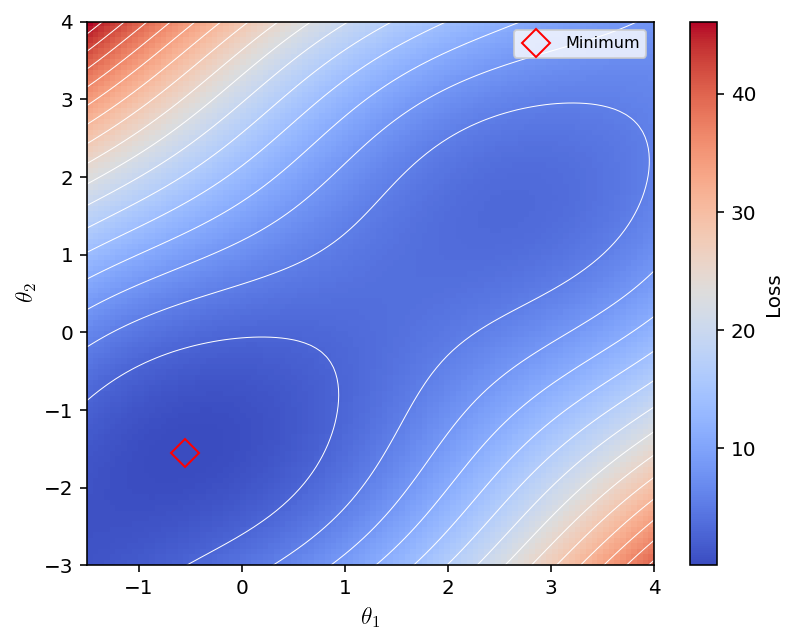

In [67]:
x, y = np.meshgrid(np.linspace(-1.5, 4, 100), np.linspace(-3, 4, 100))
z = mccormick(x, y)

fig = plt.figure(figsize=(6.35, 5))
ax = fig.add_subplot(1, 1, 1)
ax.contour(x, y, z, levels=np.linspace(0, 80, 30), colors="white", linewidths=0.5)
im = ax.imshow(z, cmap="coolwarm", interpolation="nearest", origin="lower", aspect="auto", extent=[-1.5, 4, -3, 4])
ax.plot(-0.54719, -1.54719,  color="none", marker="D", mec="r", mfc="none", markersize=10, label="Minimum")
cb = fig.colorbar(im, ax=ax)
cb.set_label("Loss")
ax.set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
ax.set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)
ax.legend(prop={'size': 8})
plt.savefig("assets/mccormick_contour.png", dpi=200)
plt.show()

#### Batch Gradient Descent

Batch gradient descent, sometimes denoted as vanilla or full-batch gradient descent, uses the gradient of the loss function for all training examples $\nabla_{\theta}J(\theta)$, i.e. the true gradient, to update the parameters of the model. Each update consists in adding the product of the learning rate $\eta$ and the negative gradient $-\nabla_{\theta}J(\theta)$ to the parameters $\theta$.

$$\theta \leftarrow \theta - \eta \cdot \nabla_{\theta}J(\theta)$$

Computing $\nabla_{\theta}J(\theta)$ for each update is slow and considerably slows down training. For this reason, other optimiziation algorithms that compute the gradient using a fraction of the dataset are usually preferred over batch gradient descent.

In [68]:
def bgd(params: np.ndarray, lr: float, epochs: int):
    """Batch gradient descent"""
    for epoch in range(epochs):
        grad = grad_mccormick(*params)
        params = params - lr * grad
        yield params

start = np.array([-1., 2.75])
bgd_mccormick = list(bgd(start, lr=0.01, epochs=10000))

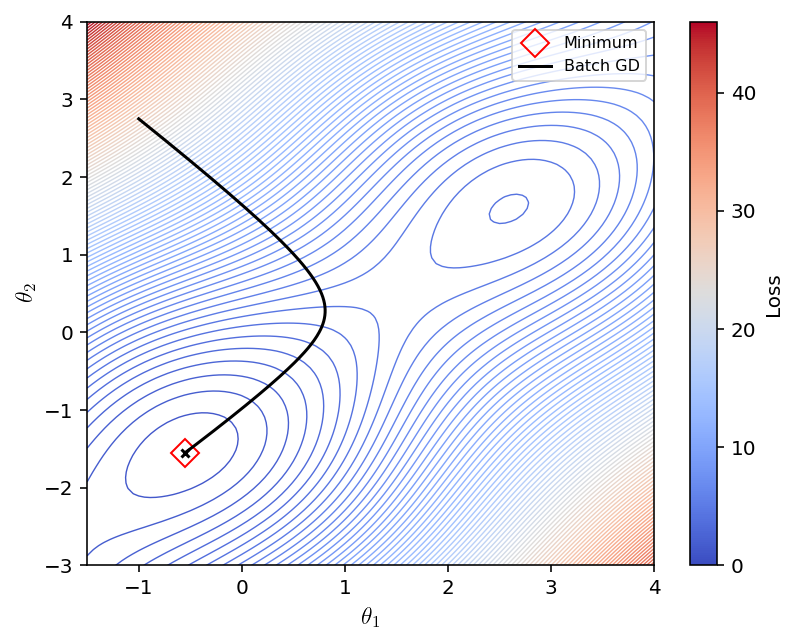

In [40]:
bgd_path = np.array([start, *bgd_mccormick])

fig = plt.figure(figsize=(6.35, 5))
ax = fig.add_subplot(1, 1, 1)
ax.contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
ax.plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Minimum")
ax.plot(bgd_path.T[0], bgd_path.T[1], color="k", linewidth=1.5, label="Batch GD")
ax.plot(*bgd_path[-1], "kx", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=ax)
cb.set_label("Loss")
ax.set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
ax.set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)
ax.legend(prop={'size': 8})
plt.savefig("assets/mccormick_bgd.png", dpi=200)
plt.show()

#### Stochastic Gradient Descent

***Stochastic gradient descent*** (SGD) uses an approximation of the gradient $\nabla_{\theta}J(\theta)$ to optimize $J$. At each iteration, SGD randomly selects a training sample $x^{(i)}$ and its corresponding expected value $y^{(i)}$ to compute a stochastic approximation of the gradient and update the parameters $\theta$.

$$\theta \leftarrow \theta - \eta \cdot \nabla_{\theta}J(\theta; x^{(i)}, y^{(i)})$$

Samples are drawn either by randomly sampling the training data at each iteration, or by shuffling the dataset at each epoch and completing a whole pass through it. In its purest form, SGD uses a sample size of $1$, but can be generalized to larger sample sizes (see mini-batch gradient descent).

The primary advantage of SGD over batch gradient descent is that it is less computationally expensive and therefore converges faster. However, by computing only an approximation of the true gradient, SGD makes a tradeoff between speed and precision of convergence. While batch gradient descent has small gradients near minima, SGD can struggle to settle near minima due to its high stochasticity. This is both an advantage and a disadvantage. ...

##### Stochasticity: Under the Hood

The gradient $\nabla_{\theta}J(\theta; x, y)$ is the mean of all gradients $\nabla_{\theta}J(\theta; x^{(i)}, y^{(i)})$.

$$\nabla_{\theta}J(\theta; x, y) = \frac{1}{n}\sum_{i=1}^n \nabla_{\theta}J(\theta; x^{(i)}, y^{(i)})$$


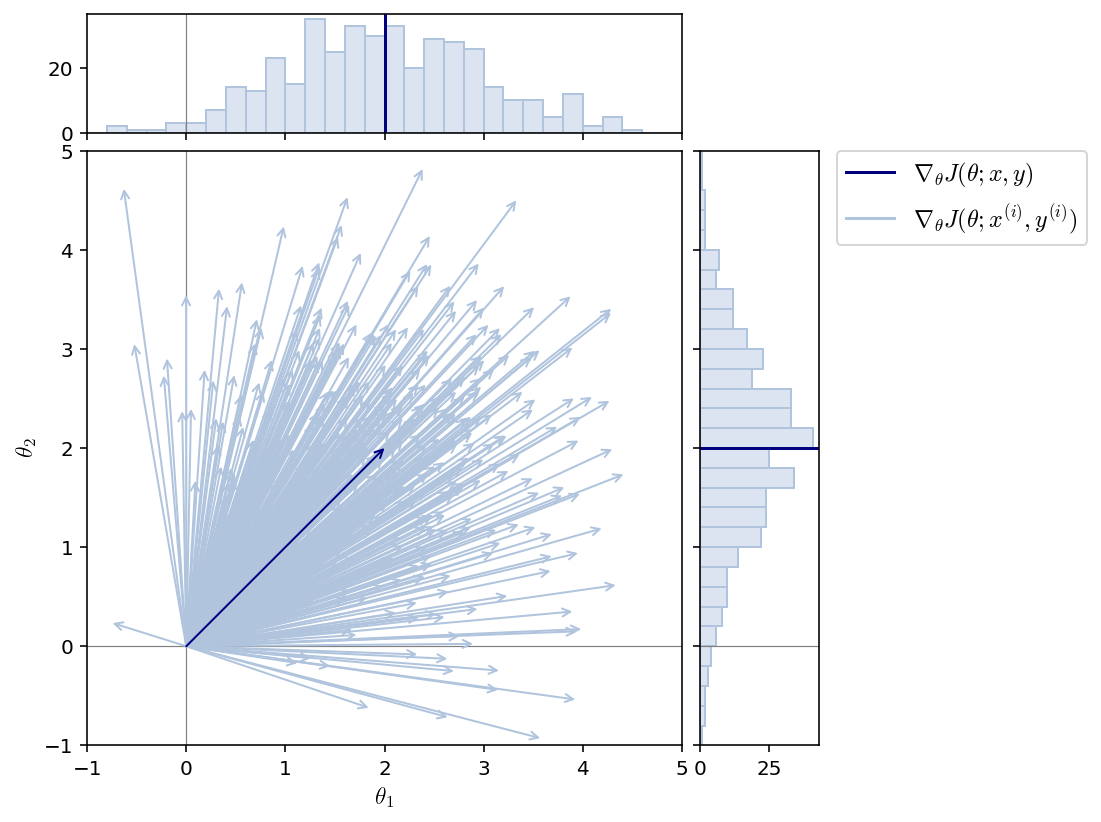

In [42]:
# Generate data
np.random.seed(0)
v = np.array([2, 2])
samples = 400
randx = np.random.normal(v[0], 1, size=(samples, 1))
randx = randx + v[0] - randx.sum() / samples
randy = np.random.normal(v[1], 1, size=(samples, 1))
randy = randy + v[1] - randy.sum() / samples
tf = np.concatenate((randx, randy), axis=1)

# Figure
fig = plt.figure(figsize=(6.35, 6.35))
gs = fig.add_gridspec(2, 2,  width_ratios=(7.5, 1.5), height_ratios=(1.5, 7.5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# No labels on axes of histograms
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

# Plot vectors
for x in tf:
    ax.annotate("", xy=tuple(x), xytext=(0, 0), arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color="lightsteelblue"))
ax.annotate("", xy=(2, 2), xytext=(0, 0), arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color="navy"))
ax.axis((-1, 5, -1, 5))
ax.axvline(0, linewidth=0.6, color="grey")
ax.axhline(0, linewidth=0.6, color="grey")

# Histograms
binwidth = 0.2
bins = np.arange(-1, 5+binwidth, binwidth)

# Alt red color scheme
# Instance grad: #ffbfbf; full-batch grad: #ff0000; hist fill: #ffbfbf; hist edge: #ff8f8f

# 2bcbff
ax_histx.hist(tf.T[0], density=False, bins=bins, color="#dbe4f0", edgecolor="lightsteelblue")
ax_histx.axvline(tf.T[0].mean(), color="navy", linewidth=1.5)
ax_histx.axvline(0, color="grey", linewidth=0.6)
ax_histy.hist(tf.T[1], density=False, bins=bins, color="#dbe4f0", edgecolor="lightsteelblue", orientation='horizontal')
ax_histy.axhline(tf.T[1].mean(), color="navy", linewidth=1.5)
ax_histy.axhline(0, color="grey", linewidth=0.6)

# Legend
ax.plot([], [], c="navy", label=r"$\nabla_{\theta}J(\theta; x, y)$")
ax.plot([], [], c="lightsteelblue", label= r"$\nabla_{\theta}J(\theta; x^{(i)}, y^{(i)})$")
ax.set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
ax.set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)
ax.legend(loc="upper left", bbox_to_anchor=(1.24, 1.02), prop={"size": 12})
plt.savefig("assets/stochasticity.png", dpi=200, bbox_inches='tight')
plt.show()

##### Simulating Stochasticity

In [69]:
def simulate_grad(x, y, dataset_size, batch_size):
    """Synthetic simulation of the gradient"""
    # Calculate the real gradient
    grad = grad_mccormick(x, y)
    # Generate a sample of partial derivatives of x with standard deviation of 16
    distx = np.random.normal(grad[0], 16, size=(dataset_size, 1))
    distx += grad[0] - distx.sum() / dataset_size
    # Generate a sample of partial derivatives of y with standard deviation of 4
    disty = np.random.normal(grad[1], 4, size=(dataset_size, 1))
    disty += grad[1] - disty.sum() / dataset_size
    grads = np.concatenate((distx, disty), axis=1)
    # Sample a mini-batch and find its mean gradient
    idx = np.random.choice(grads.shape[0], batch_size, replace=False)
    grads = grads[idx, :]
    return grads.sum(axis=0) / batch_size

In [70]:
def sgd(data, params: np.ndarray, lr: float, epochs: int):
    """Stochastic Gradient Descent"""
    for epoch in range(epochs):
        for instance in data:
            grad = simulate_grad(params[0], params[1], len(data), 1)
            params = params - lr * grad
            yield params

np.random.seed(5)
data = np.linspace(0, 1, 40)
sgd_mccormick = list(sgd(data, start, lr=0.001, epochs=300))

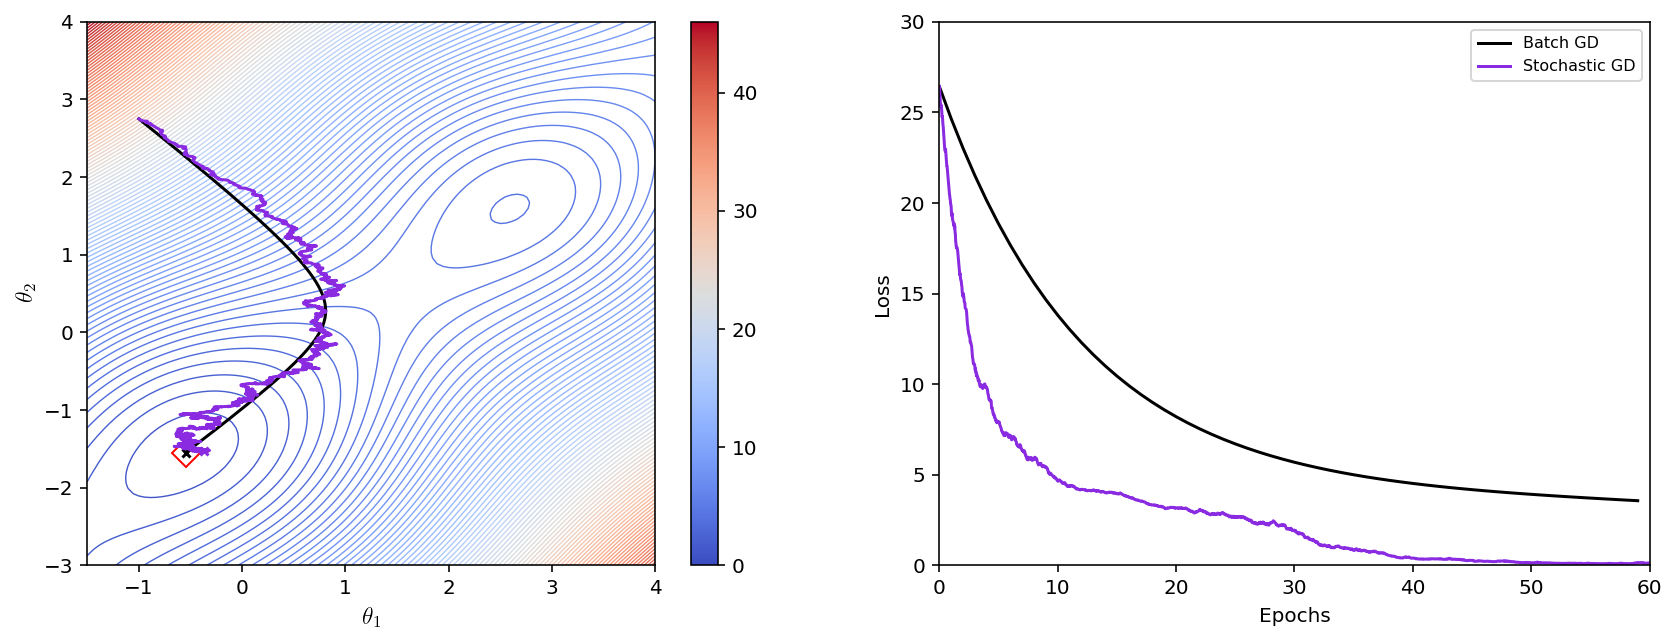

In [50]:
sgd_path = np.array([start, *sgd_mccormick])
# 60 epochs * 40 steps per epoch = 2400 steps
epochs = 60
sgd_path = sgd_path[:2400]

fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))

axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Global Minimum")
# Plot the path of batch gradient descent
axes["A"].plot(bgd_path.T[0], bgd_path.T[1], color="k", linewidth=1.5, label="BGD")
axes["A"].plot(*bgd_path[-1], "kx", markersize=4, markeredgewidth=1.5)
# Plot the path of SGD
axes["A"].plot(sgd_path.T[0], sgd_path.T[1], color="blueviolet", linewidth=1.5, label="SGD")
axes["A"].plot(*sgd_path[-1], marker="x", color="blueviolet", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)

# Calculate the loss at each timestep
bgd_losses = [mccormick(*params) for params in bgd_path]
sgd_losses = [mccormick(*params) for params in sgd_path]
axes["B"].plot(bgd_losses[:epochs], color="k", label="Batch GD")
axes["B"].plot(np.linspace(0, epochs, epochs*len(data)), sgd_losses, color="blueviolet", label="Stochastic GD")
axes["B"].legend(prop={'size': 8})
axes["B"].set_ylim([0,30])
axes["B"].set_xlim(xmin=0, xmax=epochs)
axes["B"].set_xlabel("Epochs")
axes["B"].set_ylabel("Loss")
plt.savefig("assets/mccormick_sgd.png", dpi=200, bbox_inches='tight')
plt.show()

Todo: Revise text written below

In practice, implementing the procedure described above with every single example would be computionally very expensive. Instead, the training data is divided into mini-batches and each step performed with a mini-batch instead of with a single example. Mini-batches *approximate* the gradient of the loss function. This is called ***stochastic gradient descent***.

Gradient descent step:
1. Calculate the loss of a training example.
2. Calculate by how much the activation of each neuron in the output layer needs to change.
3. The activation of each neuron can be changed by changing the neuron's bias, changing its weights, or changing the activation from the previous layer. First, the weights and bias are changed in the direction and in proportion to the desired activation change. E.g. if we want to increase the activation of a neuron, we can increase its bias and increase the weights associated with the strongest activations in the previous layer.
4. The desired changes to the activations of the previous layer are calculated for each neuron in a layer, and summed up to find the overall desired change.
5. Recursively repeat steps 3-5 for all layers in the network.

The backpropagation routine described above is repeated for all examples in a training set and all weights and biases are averaged.

#### Mini-batch Gradient Descent

$$\theta \leftarrow \theta - \eta \cdot \nabla_{\theta}J(\theta; x^{(i:i+n)}, y^{(i:i+n)})$$

In [71]:
def minibatchgd(data, params: np.ndarray, lr: float, epochs, batch_size: int):
    """Mini-batch Gradient Descent"""
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+2]
            grad = simulate_grad(params[0], params[1], len(data), len(batch))
            params = params - lr * grad
            yield params

np.random.seed(5)
minibatch_mccormick = list(minibatchgd(data, start, lr=0.001, epochs=300, batch_size=4))

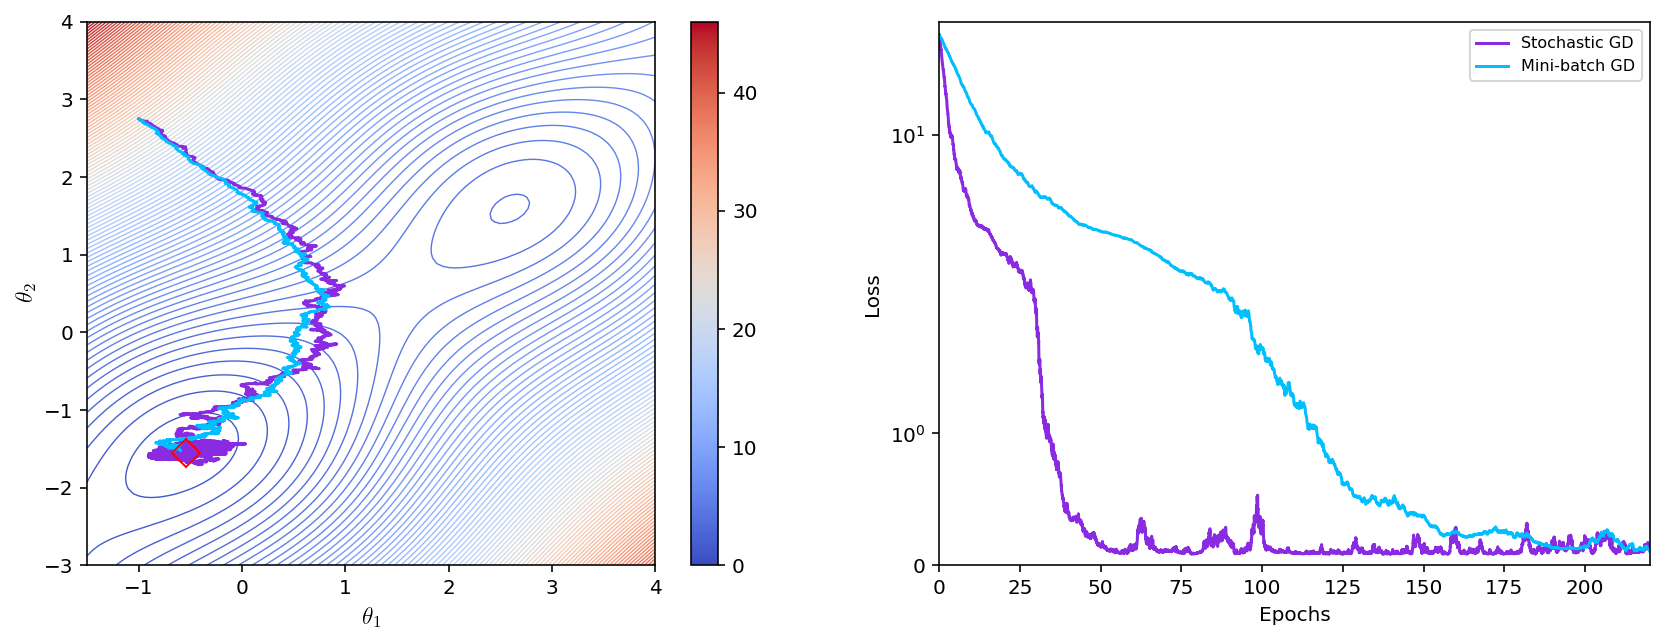

In [53]:
minibatch_path = np.array([start, *minibatch_mccormick])
# 220 epochs * (40 / 4) = 2000 steps
epochs = 220
minibatch_path = minibatch_path[:2200]
sgd_path = np.array([start, *sgd_mccormick])
# 250 epochs * 40 steps per epoch = 8000 steps
sgd_path = sgd_path[:8800]

fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))

axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
# Plot the path of SGD
axes["A"].plot(sgd_path.T[0], sgd_path.T[1], color="blueviolet", linewidth=1.5, label="Stochastic GD")
axes["A"].plot(*sgd_path[-1], marker="x", color="blueviolet", markersize=4, markeredgewidth=1.5)
# Plot the path of mini-batch gradient descent
axes["A"].plot(minibatch_path.T[0], minibatch_path.T[1], color="deepskyblue", linewidth=1.5, label="Mini-batch GD")
axes["A"].plot(*minibatch_path[-1], color="deepskyblue", marker="x", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Global Minimum")
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)

# Calculate the loss at each timestep
minibatch_losses = [mccormick(*params) for params in minibatch_path]
sgd_losses = [mccormick(*params) for params in sgd_path]
axes["B"].plot(np.linspace(0, epochs, epochs*len(data)), sgd_losses, color="blueviolet", label="Stochastic GD")
axes["B"].plot(np.linspace(0, epochs, 2200), minibatch_losses, color="deepskyblue", label="Mini-batch GD")
axes["B"].legend(prop={'size': 8})
axes["B"].set_yscale("symlog")
axes["B"].set_ylim([0,30])
axes["B"].set_xlim(xmin=0, xmax=epochs)
axes["B"].set_xlabel("Epochs")
axes["B"].set_ylabel("Loss")
plt.savefig("assets/mccormick_minibatch.png", dpi=200, bbox_inches='tight')
plt.show()

#### Momentum

$$v_t = \gamma v_{t-1} + \eta\nabla_{\theta}J(\theta)$$

$$\theta = \theta - v_t$$

A typical value for the momentum term $\gamma$ is $0.9$.

In [72]:
def momentum(params: np.ndarray, lr: float, gamma:float, epochs: int, batch_size):
    """Momentum optimizer"""
    velocity = np.zeros(params.shape)
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+2]
            grad = simulate_grad(params[0], params[1], len(data), len(batch))
            update = gamma * velocity + lr * grad
            params = params - update
            velocity = update
            yield params

np.random.seed(5)
momentum_mccormick = list(momentum(start, lr=0.0003, gamma=0.9, epochs=300, batch_size=8))

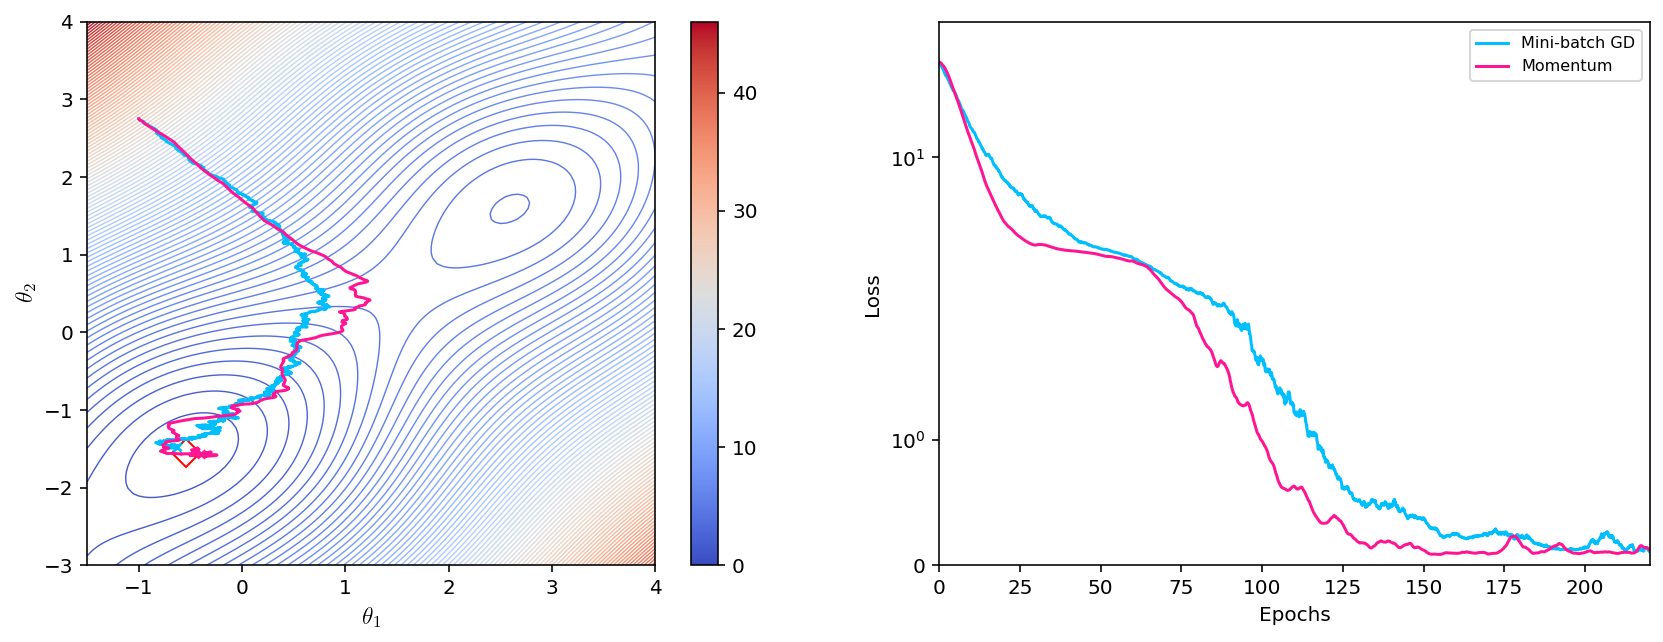

In [55]:
momentum_path = np.array([start, *momentum_mccormick])
epochs = 220
momentum_path = momentum_path[:1100]

fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))

axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Global Minimum")
# Plot the path of mini-batch gradient descent
axes["A"].plot(minibatch_path.T[0], minibatch_path.T[1], color="deepskyblue", linewidth=1.5, label="Mini-batch GD")
axes["A"].plot(*minibatch_path[-1], color="deepskyblue", marker="x", markersize=4, markeredgewidth=1.5)
# Plot the path of Momentum
axes["A"].plot(momentum_path.T[0], momentum_path.T[1], color="deeppink", linewidth=1.5, label="Momentum")
axes["A"].plot(*momentum_path[-1], color="deeppink", marker="x", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)

# Calculate the loss at each timestep
momentum_losses = [mccormick(*params) for params in momentum_path]
axes["B"].plot(np.linspace(0, epochs, 2200), minibatch_losses, color="deepskyblue", label="Mini-batch GD")
axes["B"].plot(np.linspace(0, epochs, 1100), momentum_losses, color="deeppink", label="Momentum")
axes["B"].legend(prop={'size': 8})
axes["B"].set_yscale("symlog")
axes["B"].set_ylim([0,40])
axes["B"].set_xlim(xmin=0, xmax=epochs)
axes["B"].set_xlabel("Epochs")
axes["B"].set_ylabel("Loss")
plt.savefig("assets/mccormick_momentum.png", dpi=200, bbox_inches='tight')
plt.show()

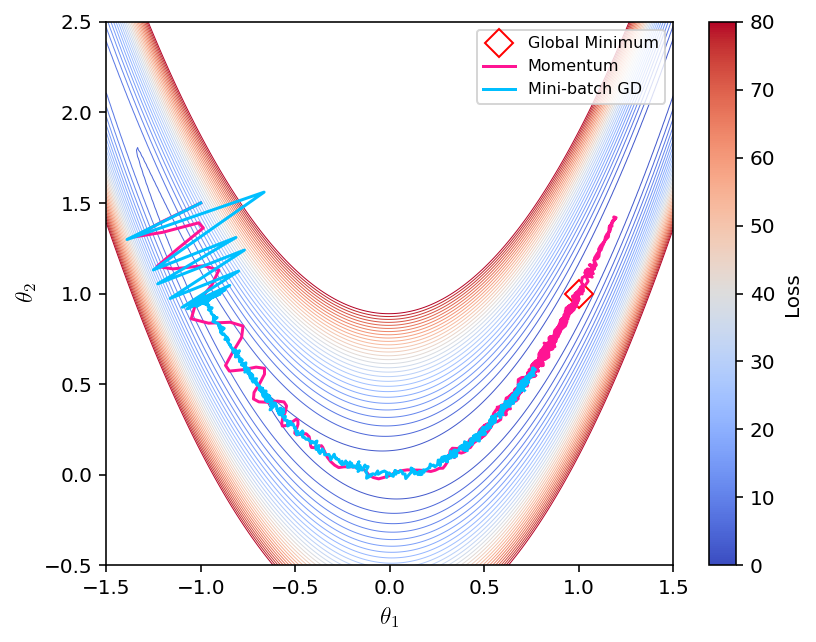

In [56]:
def rosenbrock(x, y):
    """Rosenbrock function"""
    return (1 - x)**2 + 100*(y - x**2)**2

grad_rosenbrock = jit(grad(rosenbrock, argnums=(0, 1)))
grad_rosenbrock_np = lambda x, y: np.array(grad_rosenbrock(x, y), ndmin=1)

def simulate_grad(x, y, dataset_size, batch_size):
    """Synthetic simulation of the gradient"""
    # Calculate the real gradient
    grad = grad_rosenbrock_np(x, y)
    # Generate a sample of partial derivatives of x with standard deviation of 2
    distx = np.random.normal(grad[0], 4, size=(dataset_size, 1))
    distx += grad[0] - distx.sum() / dataset_size
    # Generate a sample of partial derivatives of y with standard deviation of 2
    disty = np.random.normal(grad[1], 8, size=(dataset_size, 1))
    disty += grad[1] - disty.sum() / dataset_size
    grads = np.concatenate((distx, disty), axis=1)
    # Sample a mini-batch and find its mean gradient
    idx = np.random.choice(grads.shape[0], batch_size, replace=False)
    grads = grads[idx, :]
    return grads.sum(axis=0) / batch_size

def minibatchgd(data, params: np.ndarray, lr: float, epochs, batch_size: int):
    """Mini-batch Gradient Descent"""
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+2]
            grad = simulate_grad(params[0], params[1], len(data), len(batch))
            params = params - lr * grad
            yield params

def momentum(data, params: np.ndarray, lr: float, gamma:float, epochs: int, batch_size):
    """Momentum optimizer"""
    velocity = np.zeros(params.shape)
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+2]
            grad = simulate_grad(params[0], params[1], len(data), len(batch))
            update = gamma * velocity + lr * grad
            params = params - update
            velocity = update
            yield params

np.random.seed(1)
start = np.array([-1, 1.5])

minibatch_rosenbrock = list(minibatchgd(data, start, lr=0.002, epochs=100, batch_size=4))
minibatch_rosenbrock_path = np.array([start, *minibatch_rosenbrock])

momentum_rosenbrock = list(momentum(data, start, lr=0.001, gamma=0.9, epochs=100, batch_size=4))
momentum_rosenbrock_path = np.array([start, *momentum_rosenbrock])

x, y = np.meshgrid(np.linspace(-1.5, 1.5, 200), np.linspace(-.5, 2.5, 200))
z = rosenbrock(x, y)

fig = plt.figure(figsize=(6.35, 5))
ax = fig.add_subplot(1, 1, 1)
ax.contour(x, y, z, levels=np.linspace(0, 80, 30), cmap="coolwarm", linewidths=0.5)
ax.plot(1, 1,  color="none", marker="D", mec="r", mfc="none", markersize=10, label="Global Minimum")
# Plot the path of Momentum
ax.plot(momentum_rosenbrock_path.T[0], momentum_rosenbrock_path.T[1], color="deeppink", linewidth=1.5, label="Momentum")
ax.plot(*momentum_rosenbrock_path[-1], color="deeppink", marker="x", markersize=4, markeredgewidth=1.5)
# Plot the path of Mini-batch GD
ax.plot(minibatch_rosenbrock_path.T[0], minibatch_rosenbrock_path.T[1], color="deepskyblue", linewidth=1.5, label="Mini-batch GD")
ax.plot(*minibatch_rosenbrock_path[-1], color="deepskyblue", marker="x", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 80.)
cb = fig.colorbar(m, ax=ax)
cb.set_label("Loss")
ax.set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
ax.set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)
ax.legend(prop={'size': 8})
plt.savefig("assets/rosenbrock.png", dpi=200, bbox_inches='tight')
plt.show()

#### Adagrad

Adagrad, short for Adaptive Gradient Algorithm, is...

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot g_t$$

Slower to converge

Duchi et al. (2011) [Adaptive Subgradient Methods for Online Learning and Stochastic Optimization](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

In [73]:
def adagrad(data, params: np.ndarray, lr: float, epochs, batch_size: int, eps=1e-8):
    """Adagrad optimizer"""
    Gt = np.zeros(params.shape)
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+2]
            grad = simulate_grad(params[0], params[1], len(data), len(batch))   
            Gt += grad**2
            update = lr / np.sqrt(Gt + eps) * grad
            params = params - update
            yield params

np.random.seed(5)
adagrad_mccormick = list(adagrad(data, start, lr=0.2, epochs=300, batch_size=8))

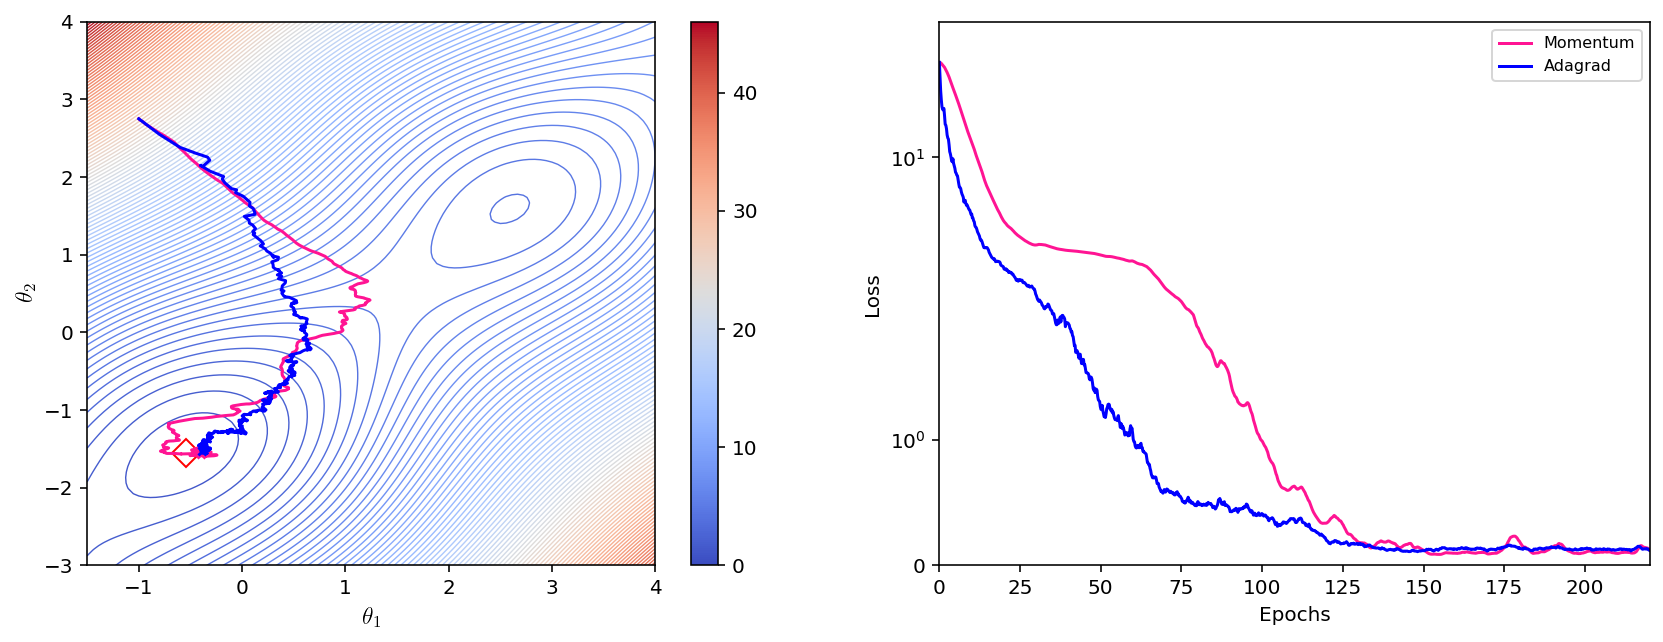

In [74]:
adagrad_path = np.array([start, *adagrad_mccormick])
epochs = 220
adagrad_path = adagrad_path[:1100]

fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))

axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Global Minimum")
# Plot the path of Momentum
axes["A"].plot(momentum_path.T[0], momentum_path.T[1], color="deeppink", linewidth=1.5, label="Momentum")
axes["A"].plot(*momentum_path[-1], color="deeppink", marker="x", markersize=4, markeredgewidth=1.5)
# Plot the path of Adagrad
axes["A"].plot(adagrad_path.T[0], adagrad_path.T[1], color="b", linewidth=1.5, label="Adagrad")
axes["A"].plot(*adagrad_path[-1], color="b", marker="x", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)

# Calculate the loss at each timestep
adagrad_losses = [mccormick(*params) for params in adagrad_path]
axes["B"].plot(np.linspace(0, epochs, 1100), momentum_losses, color="deeppink", label="Momentum")
axes["B"].plot(np.linspace(0, epochs, 1100), adagrad_losses, color="b", label="Adagrad")
axes["B"].legend(prop={'size': 8})
axes["B"].set_yscale("symlog")
axes["B"].set_ylim([0,40])
axes["B"].set_xlim(xmin=0, xmax=epochs)
axes["B"].set_xlabel("Epochs")
axes["B"].set_ylabel("Loss")
plt.savefig("assets/mccormick_adagrad.png", dpi=200, bbox_inches='tight')
plt.show()

#### RMSprop

Exponentially decaying average of squared gradients:

$$E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma)g^2_t$$

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}}g_t$$

$\gamma$ is usually set to $0.9$ and the learning rate to $0.001$

In [75]:
def rmsprop(data, params: np.ndarray, lr: float, epochs: int, gamma:float, batch_size: int, eps=1e-8):
    """RMSprop optimizer"""
    average = np.zeros(params.shape)
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+2]
            grad = simulate_grad(params[0], params[1], len(data), len(batch))
            average = gamma * average + (1 - gamma) * grad**2
            update = lr / np.sqrt(average + eps) * grad
            params = params- update
            yield params

np.random.seed(5)
rmsprop_mccormick = list(rmsprop(data, start, lr=0.01, epochs=300, gamma=0.9, batch_size=8))

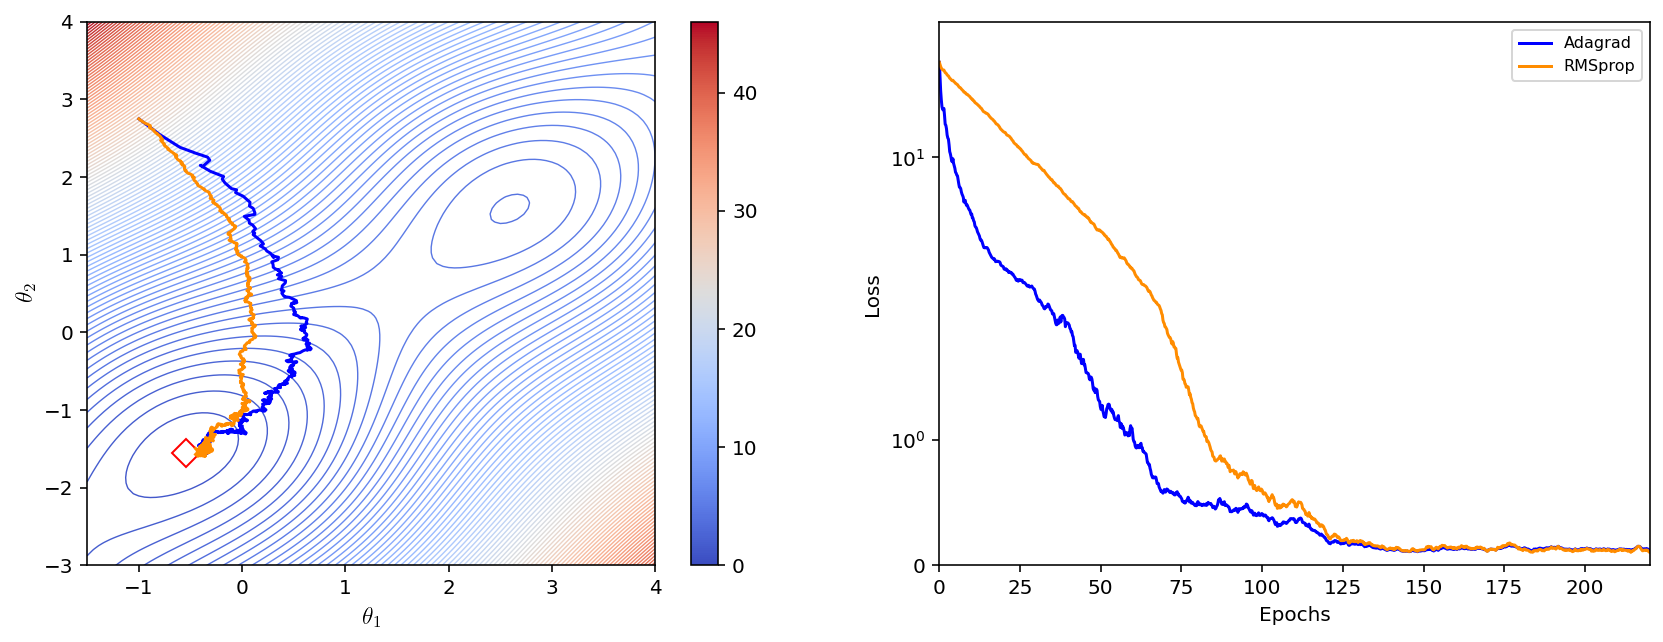

In [76]:
rmsprop_path = np.array([start, *rmsprop_mccormick])
rmsprop_path = rmsprop_path[:1100]

fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))

axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Global Minimum")
# Plot the path of Adagrad
axes["A"].plot(adagrad_path.T[0], adagrad_path.T[1], color="b", linewidth=1.5, label="Adagrad")
axes["A"].plot(*adagrad_path[-1], color="b", marker="x", markersize=4, markeredgewidth=1.5)
# Plot the path of RMSprop
axes["A"].plot(rmsprop_path.T[0], rmsprop_path.T[1], color="darkorange", linewidth=1.5, label="RMSprop")
axes["A"].plot(*rmsprop_path[-1], color="darkorange", marker="x", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)

# Calculate the loss at each timestep
rmsprop_losses = [mccormick(*params) for params in rmsprop_path]
axes["B"].plot(np.linspace(0, epochs, 1100), adagrad_losses, color="b", label="Adagrad")
axes["B"].plot(np.linspace(0, epochs, 1100), rmsprop_losses, color="darkorange", label="RMSprop")
axes["B"].legend(prop={'size': 8})
axes["B"].set_yscale("symlog")
axes["B"].set_ylim([0,40])
axes["B"].set_xlim(xmin=0, xmax=epochs)
axes["B"].set_xlabel("Epochs")
axes["B"].set_ylabel("Loss")
plt.savefig("assets/mccormick_rmsprop.png", dpi=200, bbox_inches='tight')
plt.show()

#### Adam

Kingma and Ba (2015) Adam: A Method For Stochastic Optimization [Link](https://arxiv.org/pdf/1412.6980.pdf)

Adam (Adaptive Moment Estimation)

$$m_t = \beta_1 m_{t - 1} + (1 - \beta_1)g_t$$

$$v_t = \beta_2 v_{t - 1} + (1 - \beta_2)g_t^2$$

$$\hat{m_t} = \frac{m_t}{1 - \beta_1^t}$$

$$\hat{v_t} = \frac{v_t}{1 - \beta_2^t}$$

$$\theta_{t + 1} = \theta_t - \frac{\eta}{\sqrt{\hat{v_t}} + \epsilon}\hat{m_t}$$

In [77]:
def adam(data, params: np.ndarray, lr: float, epochs: int, b1, b2, batch_size: int, eps=1e-8):
    """Adam optimizer"""
    m = np.zeros(params.shape)
    v = np.zeros(params.shape)
    for epoch in range(epochs):
        for i in range(0, len(data), batch_size):
            batch = data[i:i+2]
            grad = simulate_grad(params[0], params[1], len(data), batch_size)
            m = b1 * m + (1 - b1) * grad
            v = b2 * v + (1 - b2) * grad**2
            update = lr / (np.sqrt(v / (1 - b2)) + eps) * (m / (1 - b1))
            params = params - update 
            yield params

np.random.seed(5)
adam_mccormick = list(adam(data, start, lr=0.03, epochs=300, b1=0.9, b2=0.999, batch_size=8))

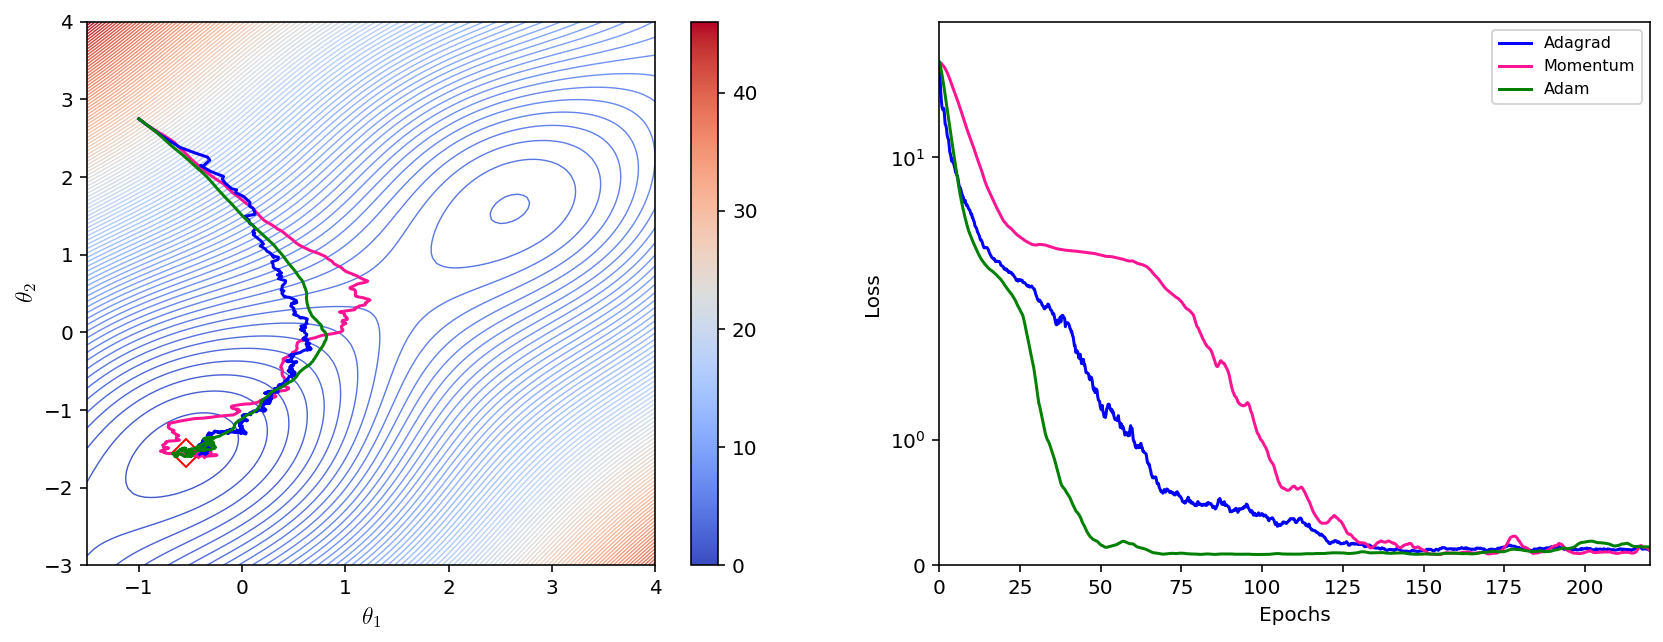

In [78]:
adam_path = np.array([start, *adam_mccormick])
adam_path = adam_path[:1100]

fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))

axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Global Minimum")
# Plot the path of Momentum
axes["A"].plot(momentum_path.T[0], momentum_path.T[1], color="deeppink", linewidth=1.5, label="Momentum")
axes["A"].plot(*momentum_path[-1], color="deeppink", marker="x", markersize=4, markeredgewidth=1.5)
# Plot the path of Adagrad
axes["A"].plot(adagrad_path.T[0], adagrad_path.T[1], color="b", linewidth=1.5, label="Adagrad")
axes["A"].plot(*adagrad_path[-1], color="b", marker="x", markersize=4, markeredgewidth=1.5)
# Plot the path of Adam
axes["A"].plot(adam_path.T[0], adam_path.T[1], color="g", linewidth=1.5, label="Adam")
axes["A"].plot(*adam_path[-1], color="g", marker="x", markersize=4, markeredgewidth=1.5)
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)

# Calculate the loss at each timestep
adam_losses = [mccormick(*params) for params in adam_path]
axes["B"].plot(np.linspace(0, epochs, 1100), adagrad_losses, color="b", label="Adagrad")
axes["B"].plot(np.linspace(0, epochs, 1100), momentum_losses, color="deeppink", label="Momentum")
axes["B"].plot(np.linspace(0, epochs, 1100), adam_losses, color="g", label="Adam")
axes["B"].legend(prop={'size': 8})
axes["B"].set_yscale("symlog")
axes["B"].set_ylim([0,40])
axes["B"].set_xlim(xmin=0, xmax=epochs)
axes["B"].set_xlabel("Epochs")
axes["B"].set_ylabel("Loss")
plt.savefig("assets/mccormick_adam.png", dpi=200, bbox_inches='tight')
plt.show()

In [79]:
mpl.rcParams["savefig.bbox"] = "tight"

In [80]:
# Figure
fig, axes = plt.subplot_mosaic(mosaic="AB", figsize=(14, 5))
axes["A"].contour(x, y, z, levels=np.linspace(-1, 46, 100), cmap="coolwarm", linewidths=0.7)
axes["A"].plot(-0.54719, -1.54719, color="none", marker="D", mec="r", mfc="none", markersize=10, label="Minimum")
m = plt.cm.ScalarMappable(cmap="coolwarm")
m.set_clim(0., 46.)
cb = fig.colorbar(m, ax=axes["A"])
axes["A"].set_xlabel(r"$\theta_1$", usetex=True, fontsize=12)
axes["A"].set_ylabel(r"$\theta_2$", usetex=True, fontsize=12)

# Animated gradient descent paths
# Mini-batch GD
minibatch_line, = axes["A"].plot([], [], color="deepskyblue", linewidth=1.5, label="Mini-batch GD")
minibatch_marker, = axes["A"].plot([], [], color="deepskyblue", marker="o", markersize=3, markeredgewidth=1.5)
# Momentum
momentum_line, = axes["A"].plot([], [], color="deeppink", linewidth=1.5, label="Momentum")
momentum_marker, =  axes["A"].plot([], [], color="deeppink", marker="o", markersize=3, markeredgewidth=1.5)
# Adagrad
adagrad_line, = axes["A"].plot([], [], color="b", linewidth=1.5, label="Adagrad")
adagrad_marker, =  axes["A"].plot([], [], color="b", marker="o", markersize=3, markeredgewidth=1.5)
# RMSprop
rmsprop_line, = axes["A"].plot([], [], color="darkorange", linewidth=1.5, label="RMSprop")
rmsprop_marker, =  axes["A"].plot([], [], color="darkorange", marker="o", markersize=3, markeredgewidth=1.5)
# Adam
adam_line, = axes["A"].plot([], [], color="g", linewidth=1.5, label="Adam")
adam_marker, =  axes["A"].plot([], [], color="g", marker="o", markersize=3, markeredgewidth=1.5)

axes["A"].legend(prop={'size': 8})


# Animated loss graphs
# Mini-batch GD
minibatch_loss, = axes["B"].plot([], [], color="deepskyblue", label="Mini-batch GD")
# Momentum
momentum_loss, = axes["B"].plot([], [], color="deeppink", label="Momentum")
# Adagrad
adagrad_loss, = axes["B"].plot([], [], color="b", label="Adagrad")
# RMSprop
rmsprop_loss, = axes["B"].plot([], [], color="darkorange", label="RMSprop")
# Adam
adam_loss, = axes["B"].plot([], [], color="g", label="Adam")

axes["B"].legend(prop={'size': 8})
axes["B"].set_yscale("symlog")
axes["B"].set_ylim([0,40])
axes["B"].set_xlim(xmin=0, xmax=epochs)
axes["B"].set_xlabel("Epochs")
axes["B"].set_ylabel("Loss")

# Initialization function
def init():
    # Mini-batch GD
    minibatch_line.set_data([], [])
    minibatch_loss.set_data([], [])
    minibatch_marker.set_data([], [])
    # Momentum
    momentum_line.set_data([], [])
    momentum_loss.set_data([], [])
    momentum_marker.set_data([], [])
    # Adagrad
    adagrad_line.set_data([], [])
    adagrad_loss.set_data([], [])
    adagrad_marker.set_data([], [])
    # RMSprop
    rmsprop_line.set_data([], [])
    rmsprop_loss.set_data([], [])
    rmsprop_marker.set_data([], [])
    # Adam
    adam_line.set_data([], [])
    adam_loss.set_data([], [])
    adam_marker.set_data([], [])

    return minibatch_line, minibatch_loss, minibatch_marker, \
        momentum_line, momentum_loss, momentum_marker, \
        adagrad_line, adagrad_loss, adagrad_marker, \
        rmsprop_line, rmsprop_loss, rmsprop_marker, \
        adam_line, adam_loss, adam_marker

# Animation function (called sequentially)
def animate(i):
    steps = np.linspace(0.2, i*0.2, i)
    # Mini-batch GD
    minibatch_line.set_data(*minibatch_path.T[:, :i*2])
    minibatch_loss.set_data(np.linspace(0.1, i*0.2, i*2), minibatch_losses[:i*2])
    minibatch_marker.set_data(*minibatch_path[i*2])
    # Momentum
    momentum_line.set_data(*momentum_path.T[:, :i])
    momentum_loss.set_data(steps, momentum_losses[:i])
    momentum_marker.set_data(*momentum_path[i])
    # Adagrad
    adagrad_line.set_data(*adagrad_path.T[:, :i])
    adagrad_loss.set_data(steps, adagrad_losses[:i])
    adagrad_marker.set_data(*adagrad_path[i])
    # RMSprop
    rmsprop_line.set_data(*rmsprop_path.T[:, :i])
    rmsprop_loss.set_data(steps, rmsprop_losses[:i])
    rmsprop_marker.set_data(*rmsprop_path[i])
    # Adam
    adam_line.set_data(*adam_path.T[:, :i])
    adam_loss.set_data(steps, adam_losses[:i])
    adam_marker.set_data(*adam_path[i])

    return minibatch_line, minibatch_loss, minibatch_marker, \
        momentum_line, momentum_loss, momentum_marker, \
        adagrad_line, adagrad_loss, adagrad_marker, \
        rmsprop_line, rmsprop_loss, rmsprop_marker, \
        adam_line, adam_loss, adam_marker

anim = FuncAnimation(
    fig, animate, init_func=init,
    frames=1100, interval=14,
    repeat_delay=2000, blit=True
)
plt.close()

In [81]:
anim.save('gradientdescent.mp4', dpi=200)

The paths of all all optimizers discussed so far are animated below.

<div align="center">
    <video width=95% autoplay loop muted playsinline>
        <source src="assets/gradientdescent.mp4" alt="Animation of different gradient descent algorithms">
    </video>
</div>

### Hazards

#### Dying ReLU neurons

ReLU neurons output zero if their weighted sum is negative (i.e. when they have negative weights, negative inputs or a large negative bias). While this property can be beneficial in the form of sparsity, it can become problematic if a neuron consistently outputs zero for any input values. Since $RELU'(z) = 0$ when $z <= 0$, the parameters are not updated and the neuron dies.

Mini-batch stochastic gradient descent generates new batches at each iteration and, as long as not all inputs lead to a negative weighted sum, can prevent a neuron from becoming completely inactive. However, a high learning-rate can also lead to consistently negative weighted sums by updating the weights to high negative values. A lower learning rate or the use of an alternative activation function such as *Leaky ReLU* can mitigate this issue.

#### Vanishing gradients

Gradients can diminish drastically when they are backpropagated through a deep neural network during training. By the time the error reaches the first layers, the gradient can become so small that it is  "diﬃcult to know [in] which direction the parameters should move to improve the cost function" (Goodfellow et al, 2016, p. 290). Vanishing gradients can slow down and even prevent convergence. This issue is particularly salient in Recurrent Neural Networks (RNNs), which have a high number of steps, or in networks using the sigmoid/tanh activation functions. Alleviations include paying special attention to the weight initialization scheme, or using an alternative activation function.

#### Initialization

> [...] training deep models is a suﬃciently diﬃcult task that most algorithms are strongly aﬀected by the choice of initialization. The initial point can determine whether the algorithm converges at all, with some initial points being so unstable that the algorithm encounters numerical diﬃculties and fails altogether.
>
> (Goodfellow et al., 2016, p. 301)

A key function of initialization is to break the symmetry between different neurons. If all parameters in a given dense layer were initialized with the same constant, they would all compute the same ouputs and receive the same updates. 
Random initialization breaks this symmetry and creates asymmetries that can be tweaked through backpropagation and SGD to train the neural network.

Typicaly, only the weights are initialized randomly while the biases are set to a heuristically chosen constant.

A simple method of weight intialization is to sample values from a Gaussian probability distribution with mean `0` and a standard deviation of `1`.

Minimum: -4.1724   Maximum: 4.1531
Mean:    -0.0035   SD: 1.0025


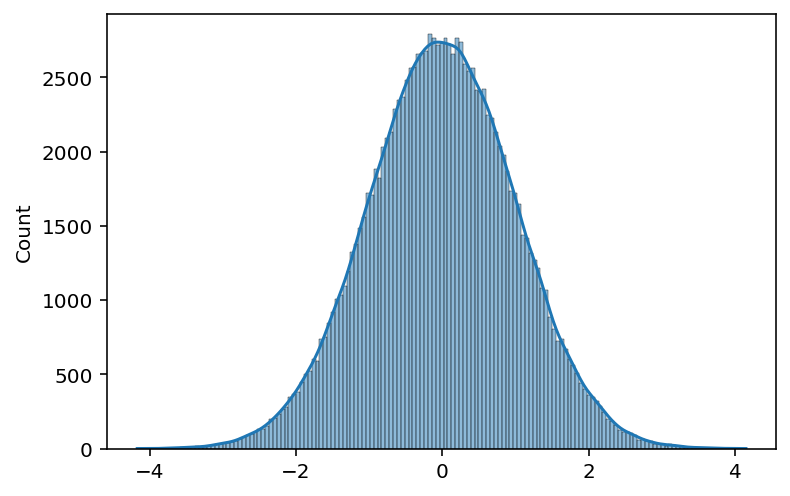

In [84]:
neurons = 256
inputs = 512

weights = np.random.randn(neurons, inputs)
hist = sns.histplot(weights.flatten(), stat="count", kde=True)
print(f"Minimum: {weights.min():.4f}   Maximum: {weights.max():.4f}")
print(f"Mean:    {weights.mean():.4f}   SD: {weights.std():.4f}")
hist.get_figure().savefig("assets/init_gaussian.png", dpi=200, bbox_inches='tight')

[**Glorot and Bengio**](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) (2010) suggest initializing a neuron's weights using a uniform probability distribution with mean 0.0 and a range that depends on the number of inputs $m$ and number of outputs $n$ of the layer.

$$W_{ij} \sim\ U\begin{pmatrix}-\sqrt{\frac{6}{m+n}},\sqrt{\frac{6}{m+n}}\end{pmatrix}$$

This method, known as ***Xavier initialization***, mantains the variance of activations and backpropagated errors thoughout the network. Neurons with a sigmoid or tanh activation function are therefore usually initialized with this method to mitigate the issue of vanishing gradients.

Minimum: -0.0884   Maximum: 0.0884
Mean:    -0.0001   SD: 0.0510


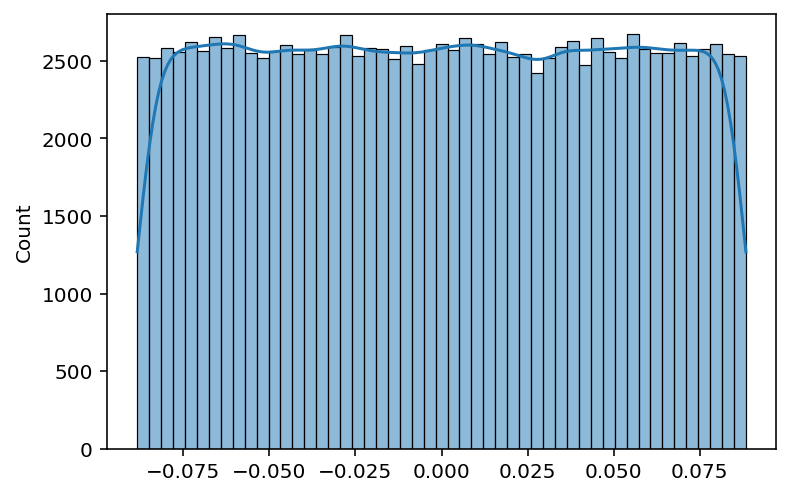

In [85]:
limit = np.sqrt(6 / (inputs+neurons))
weights = np.random.uniform(low=-limit, high=limit, size=(neurons, inputs))

hist = sns.histplot(weights.flatten(), stat="count", kde=True)
print(f"Minimum: {weights.min():.4f}   Maximum: {weights.max():.4f}")
print(f"Mean:    {weights.mean():.4f}   SD: {weights.std():.4f}")
hist.get_figure().savefig("assets/init_xavier.png", dpi=200, bbox_inches='tight')

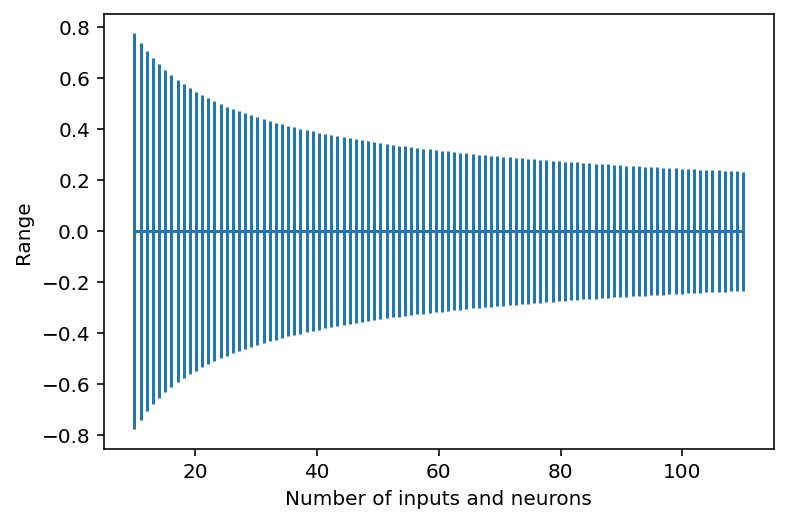

In [86]:
# The larger the number of inputs and neurons in a layer, the smaller the range of the weights
values = np.linspace(10, 110, num=100)
results = np.sqrt(6) / np.sqrt(values)
plt.errorbar(values, np.zeros(100), yerr=results)
plt.xlabel("Number of inputs and neurons")
plt.ylabel("Range")
plt.savefig("assets/init_xavier_range.png", dpi=200, bbox_inches='tight')
plt.show()

[He et al.](https://arxiv.org/abs/1502.01852) (2015) proposed a strategy tailored to networks using the ReLU activation function that, similarly to Xavier initialization, would mantain a stable activation variance throughout the network. Weights are initialized using a Gaussian probability distribution with a mean of 0.0 and a standard deviation of $\sqrt \frac{2}{n}$ where $n$ is the number of inputs to the neuron, while biases are initialized to zero. This method is now known as ***He initialization***.

Minimum: -0.2662   Maximum: 0.2944
Mean:    0.0005   SD: 0.0624


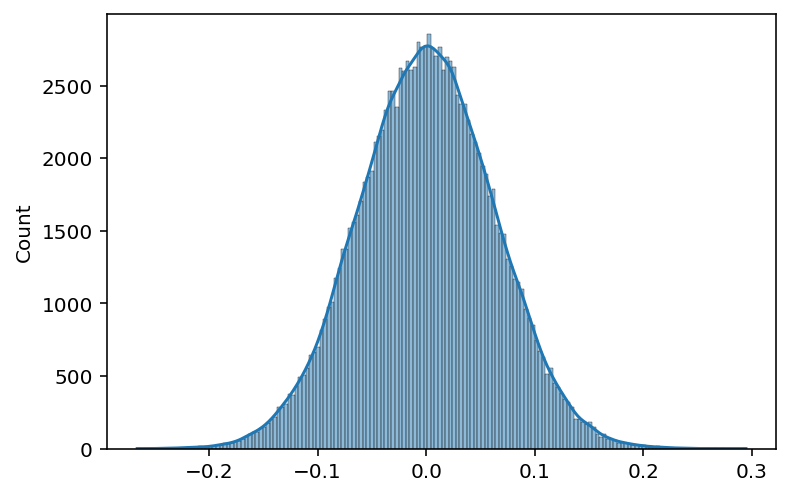

In [87]:
weights = np.random.randn(neurons, inputs) * np.sqrt(2.0 / inputs)

hist = sns.histplot(weights.flatten(), stat="count", kde=True)
print(f"Minimum: {weights.min():.4f}   Maximum: {weights.max():.4f}")
print(f"Mean:    {weights.mean():.4f}   SD: {weights.std():.4f}")
hist.get_figure().savefig("assets/init_he.png", dpi=200, bbox_inches='tight')

#### Overfitting/Underfitting

## Regularization

"Regularization is any modiﬁcation we make to a learning algorithm that is intended to reduce its generalization error but not its training error" (Goodfellow et al, 2016, p. 120).

Limiting the representative capacity of the network and increasing noise are core strategies that underpin many regularization techniques. The capacity of a model can be limited by decreasing its size or by regularizing its weights. Noise can be injected at the input level through *dataset augmentation*, at the output level through *label smoothing*, or at the neuron level through *dropout*.

### Network size

The simplest regularization method is to reduce the size of the model (i.e. lower the total number of neurons). Reducing its size limits the capacity of the model and thus forces it to learn simpler representations. Unfortunatly, it is difficult to determine the right network size. In practice, the best model is therefore oftentimes "a large model that has been regularized appropriately" (ibid, p. 229). 

### Weight regularization

Large weights place a strong emphasis on a few features and lead to high gradients. ***Weight regularization*** constrains model complexity by forcing the weights to take on smaller values such that the distribution of weights values becomes more regular. This is achieved by adding to the loss function of the model a penalty associated with having large weights (Chollet, 2021, p. 146).

$$Loss = L(y, a) + \lambda \Omega(\theta)$$

where $L(y, a)$ is the loss function, and $\Omega(\theta)$ is the regularization penalty ($L^1$ or $L^2$). $\lambda$ is a hyperparameter that indicates the strenght of the preference for smaller weights. Minimizing a loss with weight regularization compels the model to choose weights that "make a tradeoff between fitting the training data and being small" (Goodfellow et al., 2016, p. 119).

$L^p$ spaces reminder: The $p$-norm or $L^p$-norm of a vector $x$ is defined by

$${\lVert x \rVert}_p = ({\lvert x_1 \rvert}^p + {\lvert x_2 \rvert}^p + ... + {\lvert x_n \rvert}^p)^\frac{1}{p}$$

for a real number $p ≥ 1$.

#### $L^1$ regularization

With $L^1$ regularization, the added penalty is *proportional to the absolute value of the weight coefficients*.

$$\Omega(\theta) = {\left\lVert w \right\rVert}_1 = \sum_i{\lvert w_i \rvert}$$

In [ ]:
def l1_reg(w: np.ndarray):
    """L1 regularization"""
    return np.sum(np.absolute(w), axis=1, keepdims=True)

# Small weights -> small penalty
w = np.array([[-0.15, 0.2, -0.12, 0.04]])
l1_reg(w)

array([[0.51]])

In [ ]:
# Large weights -> large penalty
w = np.array([[-1.5, 2, -1.2, 0.4]])
l1_reg(w)

array([[5.1]])

In [ ]:
# Alternative implementation using Numpy's buit-in `norm()` function
np.linalg.norm(w, ord=1, axis=1, keepdims=True)

array([[5.1]])

#### $L^2$ regularization

With $L^2$ regularization (also known as ***weight decay*** in deep learning and as ridge regression or Tikhonov regularization in other fields of science) the added penalty is *proportional to the square of the value of the weight coefficients*.

$$\Omega(\theta) = {\left\lVert w \right\rVert}_2^2 = w^Tw $$

In [ ]:
def l2_reg(w: np.ndarray):
    """L2 regularization"""
    return np.dot(w, w.T)

# Small weights -> small penalty
w = np.array([[-0.15, 0.2, -0.12, 0.04]])
l2_reg(w)

array([[0.0785]])

In [ ]:
# Large weights -> large penalty
w = np.array([[-1.5, 2, -1.2, 0.4]])
l2_reg(w)

array([[7.85]])

### Max-norm constraints

A ***max-norm constraint*** is another form of regularization that *limits the magnitude of the weights*. It is implemented by enforcing a limit $c$ on the weight vector $w$ of every neuron so that

$${\left\lVert w \right\rVert}_2 < c$$

Typical values for $c$ range between 1 and 4. If the weight vector exceeds the constraint, it is scaled down. Max-norm constraints are usually enforced after each parameter update.

In [ ]:
def max_norm(w: np.ndarray, c: float):
    """Enforces a max-norm constraint on the weight tensor"""
    norm = np.linalg.norm(w, axis=1)
    if norm > c:
        return w * (c / norm)
    return w

# Small weights do not exceed the constraint
max_norm(np.array([[-0.15, 0.2, -0.12, 0.04]]), c=2)

array([[-0.15,  0.2 , -0.12,  0.04]])

In [ ]:
# Large weights exceeding the constraint are normalized
w = max_norm(np.array([[-1.5, 2, -1.2, 0.4]]), c=2)
print(f"New norm: {np.linalg.norm(w, axis=1)}\n{w}")

New norm: [2.]
[[-1.07074592  1.42766122 -0.85659673  0.28553224]]


### Dropout

***Dropout*** is a technique that randomly drops neurons from the neural network during training and thus prevents them from "co-adapting too much" (Srivastava et al., 2014). By making the training process noisy, dropout increases the robustness of the trained model.

Dropout is implemented on a per-layer basis. A hyperparameter $p$ indicates the probability that a given neuron in a layer is dropped out. Since dropout is applied only during training, the activations must be scaled so that the expected activations during training equal the actual activations at test time.

In [ ]:
def dropout(a: np.ndarray, p: float):
    """Inverted dropout: activations are scaled during training"""
    return a * (np.random.rand(*a.shape) < p) / p

# Activations of a layer
activations = np.array([[0.12], [0.5], [0.345], [0.02], [0.69]])
# Dropout probability
p = 0.5

dropout(activations, p)

array([[0.24],
       [0.  ],
       [0.  ],
       [0.04],
       [0.  ]])

### Early Stopping

The loss of a large model tends to decrease steadily during training, but the validation error can rise again when the model starts overfitting. ***Early stopping*** is a strategy to return the parameters with the lowest validation error at the end of training. Early-stopping algorithms track the validation error during training and store the model parameters each time the error reaches a new low. Training is stopped when the best recorded error has not been beaten for a pre-determined number of iterations.

Early stopping is a form of hyperparameter selection for the optimal number of training steps. Compared to other forms of regularization, it is unobstrusive and is therefore widely used.

## Normalization

Batch, layer, instance and group normalization are techniques for normalizing the hidden states of a neural network.

<div align="center">
    <img src="assets/norms.jpg" width=55% style="margin:20px" alt="Normalization methods"/>
</div>

$N$ is the batch axis, $C$ the channel axis, and $(H, W)$ are the spatial axes, i.e. the height and width.

## Assembling the Building Blocks Together

In [89]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

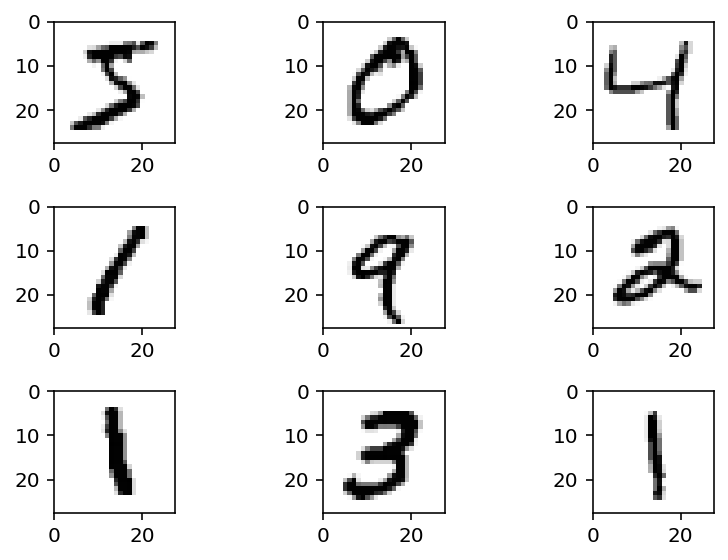

In [98]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    digit = X_train[i]
    plt.imshow(digit, cmap="binary")
    plt.xlim(xmin=0)
    plt.ylim(ymax=0)
plt.tight_layout()
plt.savefig("assets/mnist.png", dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [ ]:
X_train = X_train.reshape((60000, 784, 1))
X_test = X_test.reshape((10000, 784, 1))

Next, the expected outputs are encoded as ***one-hot vectors*** to match the output of the neural network.

In [ ]:
def vectorize_result(j):
    """Encodes the expected result as a one-hot vector"""
    v = np.zeros((10, 1))
    v[j] = 1.0
    return v

# Example
vectorize_result(6)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.]])

In [ ]:
y_train = np.array(list(map(vectorize_result, y_train)))
y_test = np.array(list(map(vectorize_result, y_test)))

Partial derivative over the cross-entropy loss function:

$$
L = CE(y, \hat{y})
\qquad\rightarrow
\qquad
\frac{\partial L}{\partial \hat{y}} = \hat{y} - y
$$

In [ ]:
class NeuralNetwork:

    def __init__(self, layers):
        self.layers: List[Layer] = layers

    def forward(self, x):
        """Forward pass through the neural network"""
        activation = x
        for layer in self.layers:
            z = np.dot(layer.weights, activation) + layer.biases
            activation = layer.activation_func(z)
        return softmax(activation)

    def loss(pred, y):
        """Cross-entropy loss function"""
        m = pred.shape[0]
        return -(1.0/m) * np.sum(y * np.log(pred) + (1-y) * np.log(1-pred))

    def backprop(self, X, y):
        """Backpropagation algorithm"""        
        # Gradient of loss function in terms of weights and biases
        gw = []
        gb = []
        # Forward pass, storing all intermediate weighted sums and activations
        activations = [X]
        zs = []
        for layer in self.layers:
            z = np.dot(layer.weights, X) + layer.biases
            X = layer.activation_func(z)
            zs.append(z)
            activations.append(X)
        # Compute loss of outputs and error of output layer
        delta = (softmax(X) - y) * self.layers[-1].activation_func(zs[-1], derivative=True)
        gb.insert(0, delta)
        gw.insert(0, np.dot(delta, activations[-2].transpose()))
        # Backpropagate the error and return the gradient
        for idx in reversed(range(len(self.layers)-1)):
            z = zs[idx]
            sp = self.layers[idx].activation_func(z, derivative=True)
            delta = np.dot(self.layers[idx+1].weights.T, delta) * sp
            gb.insert(0, delta)
            gw.insert(0, np.dot(delta, activations[idx].T))
        return gw, gb

    def train(self, X_train, y_train, X_test, y_test, epochs, learning_rate, batch_size):
        """Trains the neural network using mini-batch SGD"""
        for epoch in range(epochs):
            # Shuffle the training data
            sX, sy = shuffle(X_train, y_train)
            # Backpropagation for each batch
            for i in range(0, len(X_train), batch_size):
                # Gradient of loss function: delta of weights and biases
                gw = [np.zeros(l.weights.shape) for l in self.layers]
                gb = [np.zeros(l.biases.shape) for l in self.layers]
                for x, y in zip(sX[i:i+batch_size], sy[i:i+batch_size]):
                    dw,  db = self.backprop(x, y)
                    # Update the gradient
                    gw = [nw+dnw for nw, dnw in zip(gw, dw)]
                    gb = [nb+dnb for nb, dnb in zip(gb, db)]
                # Update the weights and biases
                for idx, (nw, nb) in enumerate(zip(gw, gb)):
                    self.layers[idx].weights = self.layers[idx].weights - (learning_rate / batch_size) * nw
                    self.layers[idx].biases = self.layers[idx].biases - (learning_rate / batch_size) * nb
            acc, loss = self.evaluate(X_test, y_test)
            print(f"Epoch {epoch} - Loss {loss} - Accuracy: {acc}")

    def predict(self, X):
        """"""
        out = self.forward(X)
        return np.argmax(out)

    def evaluate(self, X, y):
        """Evaluates the performance of the neural network"""
        outputs = np.array([self.forward(x) for x in X])
        accuracy = sum([np.argmax(out) == np.argmax(truth) for out, truth in zip(outputs, y)]) / len(X)
        print(outputs[1], y[1])
        loss = sum([self.loss(out, truth) for out, truth in zip(outputs, y)]) / len(X)
        print(sum([log_loss(truth, out) for out, truth in zip(outputs, y)]) / len(X))
        return accuracy, loss

In [ ]:
nn = NeuralNetwork([
    # Input layer: 784 inputs
    # Hidden layer 1: 32 neurons
    Layer(784, 32, sigmoid),
    # Hidden layer 2: 32 neurons
    Layer(32, 32, sigmoid),
    # Output layer: 10 neurons
    Layer(32, 10, sigmoid)
])

NameError: name 'Layer' is not defined

## Training

In [ ]:
nn.train(X_train, y_train, X_test, y_test, epochs=10, learning_rate=3, batch_size=10)

## Inference

In [ ]:
n = 8
truth = np.argmax(y_test[n])
pred = nn.predict(X_test[n])
print(pred, truth)

6 5


## References

- [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/)
- [Kaggle - Rectified Linear Units (ReLU) in Deep Learning](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning)
- [Quora - What is the role of the activation function in a neural network](https://www.quora.com/What-is-the-role-of-the-activation-function-in-a-neural-network-How-does-this-function-in-a-human-neural-network-system)
- [Wikipedia - Action potential](https://en.wikipedia.org/wiki/Action_potential)
- [Medium - Understanding Activation Functions in Neural Networks](https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0)
- [Michael Nielsen - Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/)
- [Glorot and Bengio - Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
- [Srivastava et al. - Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://dl.acm.org/doi/pdf/10.5555/2627435.2670313)
- [Baydin et al. - Automatic Differentiation in Machine Learning: a Survey](https://arxiv.org/pdf/1502.05767.pdf)

NameError: name 'nonlinear' is not defined

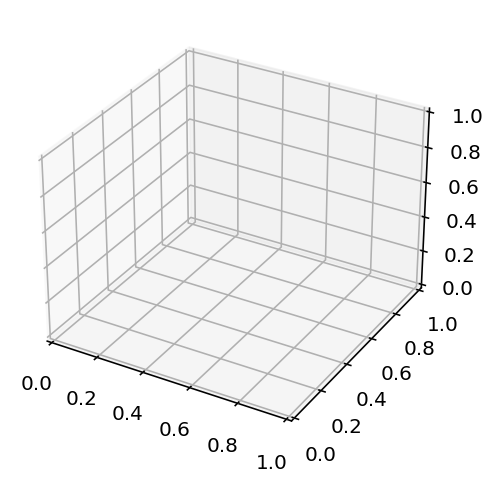

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
i = np.linspace(-10, 10, 100)
x, y = np.meshgrid(i, i)
z = np.array([[nonlinear(weights=[0.4, 0.9], input=[i1, i2[0]], bias=1.5) for i1 in x[0]] for i2 in y])
plasma = cm.get_cmap("plasma")
ax.plot_surface(x, y, z, rstride=2, cstride=2, cmap=plasma, linewidth=0, antialiased=True, shade=False)
ax.set_zlabel('Activation')
ax.view_init(azim=315)

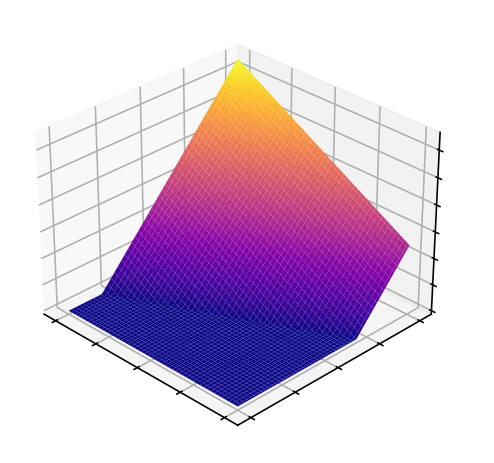

In [ ]:
def relu(weights, input, bias):
    sum = np.dot(weights, input) + bias
    return np.maximum(0, sum)

ax = plt.figure().add_subplot(projection='3d')
i = np.linspace(-10, 10, 100)
x, y = np.meshgrid(i, i)
z = np.array([[relu(weights=[-0.2, 0.4], input=[i1, i2[0]], bias=0.5) for i1 in x[0]] for i2 in y])
ax.plot_surface(x, y, z, rstride=2, cstride=2, cmap="plasma", linewidth=0, antialiased=True, shade=False)
ax.view_init(azim=315)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.savefig('logo.jpg', format="jpg", facecolor=ax.get_facecolor(), dpi=1200)

In [ ]:
# Setup: dataset with n instances
data = []
batch_size = 8

# Calculate the real gradient
grad = grad_mccormick_np(x, y)

# ANGLE
# Generate n random numbers with the mean 0 and standard deviation 30
thetas = np.random.normal(0, 30, 10)
# Enforce a sum of 0
thetas = thetas - np.sum(thetas) / len(thetas)
# Convert randn to radians and multiply grad with the rotations matrices
thetas = (thetas / 180) * np.pi
rotations =  np.array([[
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
] for theta in thetas])
grads = grad @ rotations

# MAGNITUDE
# Generate n random numbers with mean 1 and standard deviation 1
magns = np.random.normal(0, 1, (10, 1))
# Enforce a mean of 1
magns = magns + (1 - np.mean(magns))
# Mutliply n grads with the random numbers
grads = np.squeeze(grads) * magns

# Sample gradients
idx = np.random.choice(grads.shape[0], batch_size, replace=False)
grads = grads[idx, :]